# EHH decay artwork

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}
rcParams['figure.dpi'] = 120
rcParams['figure.facecolor'] = 'w'

In [2]:
# grab the npy array made in ag1000g paper 1 vgsc notebook
p1clus = np.load('../data/vgsc_cluster_membership.npy')

In [3]:
# make this into a dictionary
p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
np.unique(p1list)[1:], len(p1list)

(array(['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5'], 
       dtype='<U2'), 1530)

In [4]:
nlist = list(np.unique(p1list)[1:])
nlist

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

In [5]:
clust_dict = {n: set(np.nonzero(p1list == n)[0]) for n in nlist}
#clust_dict['S2']

In [6]:
tbl_variants_selected = etl.frompickle('../data/tbl_variants_missense_selected.pkl')
tbl_variants_selected

0|CHROM,1|POS,2|num_alleles,3|REF,4|ALT,5|AC,6|ALTIX,7|FILTER_PASS,8|NoCoverage,9|LowCoverage,10|HighCoverage,11|LowMQ,12|HighMQ0,13|RepeatDUST,14|RepeatMasker,15|RepeatTRF,16|FS,17|HRun,18|QD,19|ReadPosRankSum,20|SNPEFF_Allele,21|SNPEFF_Annotation,22|SNPEFF_HGVS_c,23|SNPEFF_HGVS_p,24|SNPEFF_Feature_ID,25|SNPEFF_CDS_pos,26|AF_AOM,27|AF_BFM,28|AF_GWA,29|AF_GNS,30|AF_BFS,31|AF_CMS,32|AF_GAS,33|AF_UGS,34|AF_KES,35|check_allele,36|exon_start,37|exon_end,38|exon,39|AGAP004707-RA,40|AGAP004707-RB,41|AGAP004707-RC,42|Davies-C1N2,43|Davies-C3N2,44|Davies-C5N2,45|Davies-C7N2,46|Davies-C8N2,47|Davies-C10N2,48|Davies-C11N2,49|Davies-C1N9,50|Davies-C8N9,51|Davies-C1N9ck
2L,2390177,2,G,A,198,0,True,0,3,8,0,0,False,False,False,0.12695,1,18.625,0.83496,A,missense_variant,n.761G>A,p.Arg254Lys,AGAP004707-RA,761,0.0,0.0,0.0,0.0,0.0,0.316363636364,0.214285714286,0.0,0.0,True,2390129,2390341,7,R254K,R254K,R254K,R260K,R217K,R260K,R260K,R271K,R260K,R260K,R260K,R271K,R260K
2L,2391228,3,G,C,10,0,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,C,missense_variant,n.1204G>C,p.Val402Leu,AGAP004707-RA,1204,0.0,0.0724637681159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2391228,3,G,T,9,1,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,None,None,None,None,None,None,0.0,0.0652173913043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2399997,2,G,C,38,0,True,0,1,7,0,0,False,False,False,13.359,0,15.688,0.11798,C,missense_variant,n.1396G>C,p.Asp466His,AGAP004707-RA,1396,0.0,0.0,0.0,0.0,0.0,0.0690909090909,0.0,0.0,0.0,True,2399898,2400173,11i+,D466H,D466H,D466H,D472H,D429H,D417H,D472H,D483H,D472H,D472H,D472H,D483H,D472H
2L,2400071,3,G,A,16,0,True,0,0,8,0,0,False,False,False,5.6875,0,16.969,1.3232,A,missense_variant,n.1470G>A,p.Met490Ile,AGAP004707-RA,1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818181818,True,2399898,2400173,11i+,M490I,M490I,M490I,M496I,M453I,M441I,M496I,M507I,M496I,M496I,M496I,M507I,M496I


In [7]:
aa2pos = tbl_variants_selected.lookupone('AGAP004707-RA', 'POS')

In [8]:
aa2pos['R254K']

2390177

In [9]:
aa2pos['L995F']

2422652

In [10]:
aa2pos['L995S']

2422651

In [11]:
aa2pos['I1527T']

2429617

In [12]:
aa2pos['M490I']

2400071

In [13]:
aa2pos['V1254I']

2425077

In [14]:
callset_haps = np.load('../data/haps_phase1.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [15]:
pos

0,1,2,3,4,...,341993,341994,341995,341996,341997
44688,44691,44732,44736,44756,...,5999246,5999251,5999252,5999253,5999254


In [16]:
def setup_ehh_data():
    global haps_ehh
    global pos_ehh

#     # load haplotypes
#     callset_haps = np.load('../data/haps_phase1.npz')
#     haps = allel.HaplotypeArray(callset_haps['haplotypes'])
#     pos = allel.SortedIndex(callset_haps['POS'])
#     ann = callset_haps['ANN']

    # perform allele count - needed to locate singletons  
    ac = haps.count_alleles(max_allele=3)

    # define types of variants to include in EHH analysis - should be mostly neutral
    loc_type_neutral = ((ann['Annotation'] == b'intergenic_region') | 
                        (ann['Annotation'] == b'intron_variant') |
                        (ann['Annotation'] == b'downstream_gene_variant') |
                        (ann['Annotation'] == b'upstream_gene_variant') |
                        (ann['Annotation'] == b'synonymous_variant') |
                        (ann['Annotation'] == b'3_prime_UTR_variant') |
                        (ann['Annotation'] == b'5_prime_UTR_variant') 
                        )
    print('neutral', np.count_nonzero(loc_type_neutral), loc_type_neutral.shape)

    # locate singletons - will exclude from EHH analysis
    # NB the EHH analysis doesn't need the multiallelics 
    loc_sgl_bi = (ac[:, :2].min(axis=1) == 1) & (ac.is_biallelic_01())
    loc_nosgl_bi = (ac[:, :2].min(axis=1) > 1) & (ac.is_biallelic_01())
    print('sgl/nosgl', np.count_nonzero(loc_sgl_bi), np.count_nonzero(loc_nosgl_bi), loc_nosgl_bi.shape)

    # these are the variants to use for EHH 
    loc_ehh = loc_type_neutral & loc_nosgl_bi
    
    # add back in driver mutations
    for aa in 'L995S', 'L995F', 'I1527T':
        loc_ehh[pos.locate_key(aa2pos[aa])] = True
    
    print('ehh', np.count_nonzero(loc_ehh), loc_ehh.shape)

    haps_ehh = haps[loc_ehh]
    pos_ehh = pos[loc_ehh]
    
setup_ehh_data()

neutral 326952 (341998,)
sgl/nosgl 107220 234555 (341998,)
ehh 225793 (341998,)


In [17]:
pos_ehh

0,1,2,3,4,...,225788,225789,225790,225791,225792
44691,44732,44756,44767,44872,...,5999246,5999251,5999252,5999253,5999254


In [18]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [19]:
cluster_labels = sorted(clust_dict)
cluster_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

## Identify core haplotypes

In [39]:
def plot_delta_af(core, flank, set1, set2, figsize=(10, 2)):
    
    # subset to region
    loc_region = pos_ehh.locate_range(core - flank, core + flank)
    pos_region = pos_ehh[loc_region]
    n_snps = pos_region.shape[0]
    haps_region = haps_ehh[loc_region]
    
    # compute delta allele frequency
    subpops = {set1: sorted(clust_dict[set1]), set2: sorted(clust_dict[set2])}
    acs = haps_region.count_alleles_subpops(subpops)
    aaf1 = acs[set1].to_frequencies()[:, 1]
    aaf2 = acs[set2].to_frequencies()[:, 1]
    delta_af = np.fabs(aaf1 - aaf2)
    loc_nz = delta_af > 0.1
    pos_region = pos_region[loc_nz]
    delta_af = delta_af[loc_nz]
    
    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(ax=ax, offset=5)
#     x = np.concatenate([-np.arange(0, idx_core)[::-1], 
#                         np.arange(idx_core, n_snps) - idx_core])
#     y = delta_af

    ax.plot(pos_region, delta_af, marker='o', mec='k', mfc='none', linestyle=' ')
    loc_diff = delta_af > .9
    pos_diff = pos_region[loc_diff]
    ax.set_xticks(pos_diff)
    ax.set_xticklabels(pos_diff - core)
    ax.axvline(core, linestyle='--', lw=1)
    ax.grid(axis='both')
    ax.set_title('%s vs %s' % (set1, set2))
    ax.set_xlim(core - flank, core + flank)
    ax.set_ylabel('Delta allele frequency')
    ax.set_xlabel('Position relative to core (bp)')
    ax.set_ylim(-0.03, 1.03)


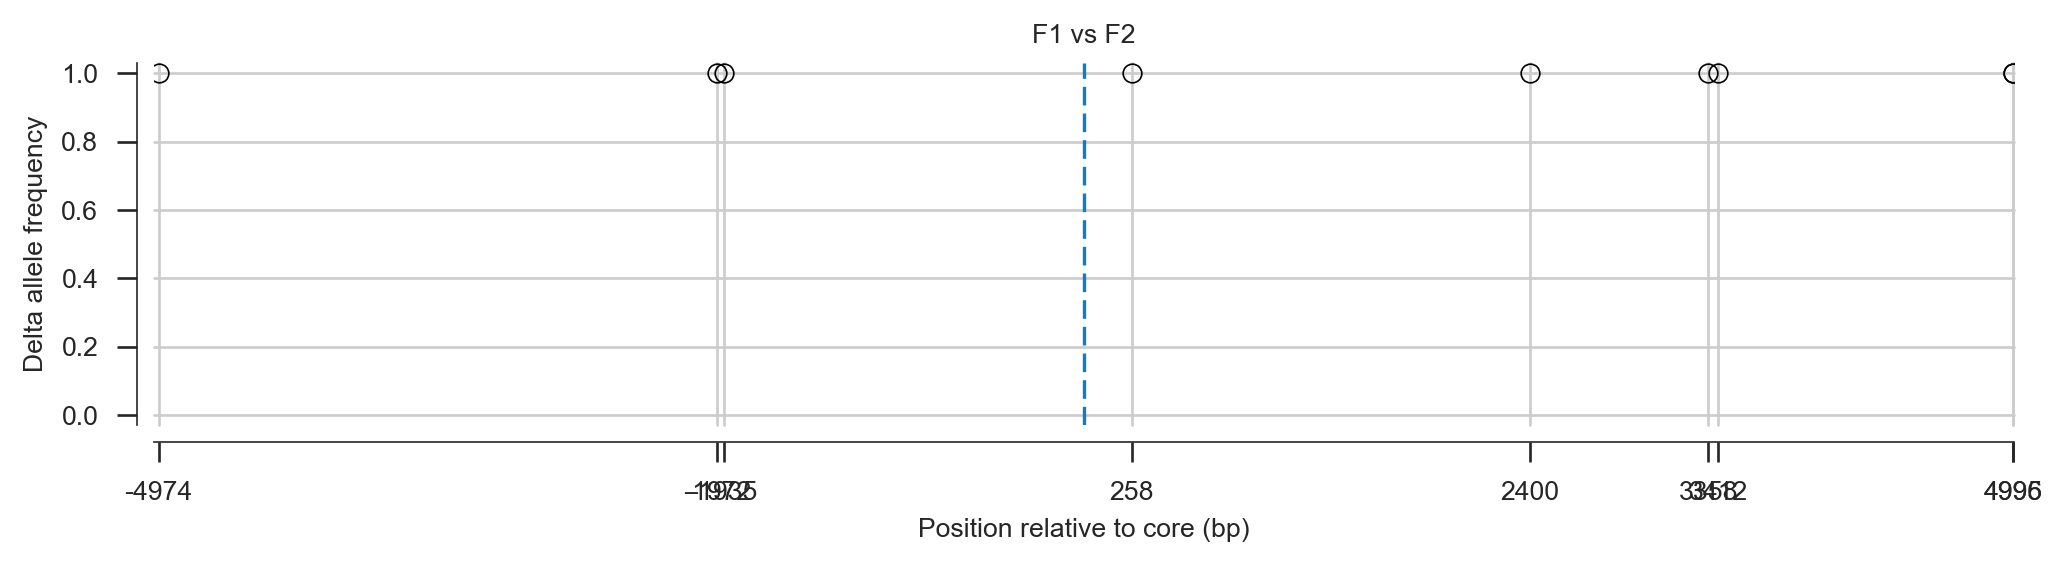

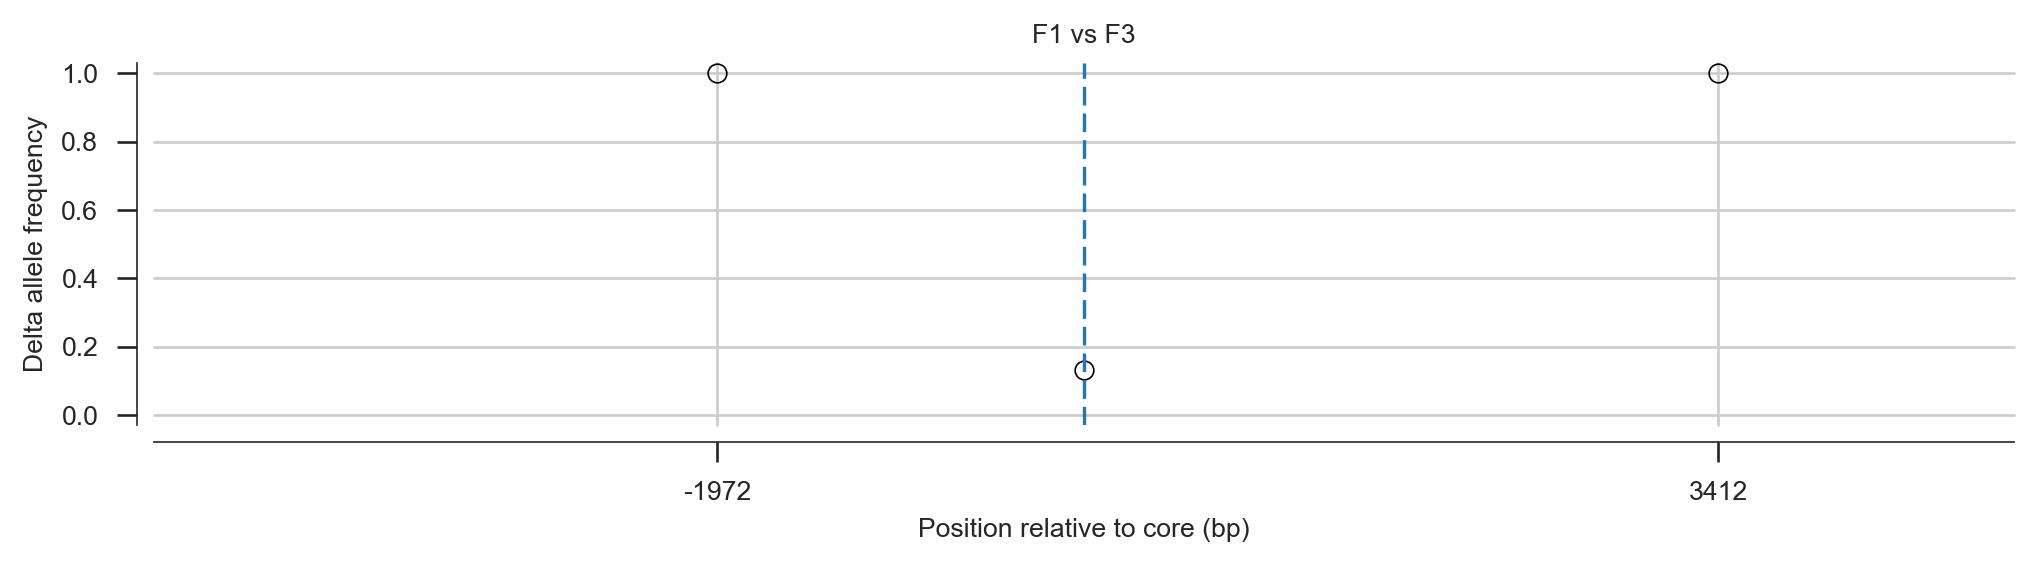

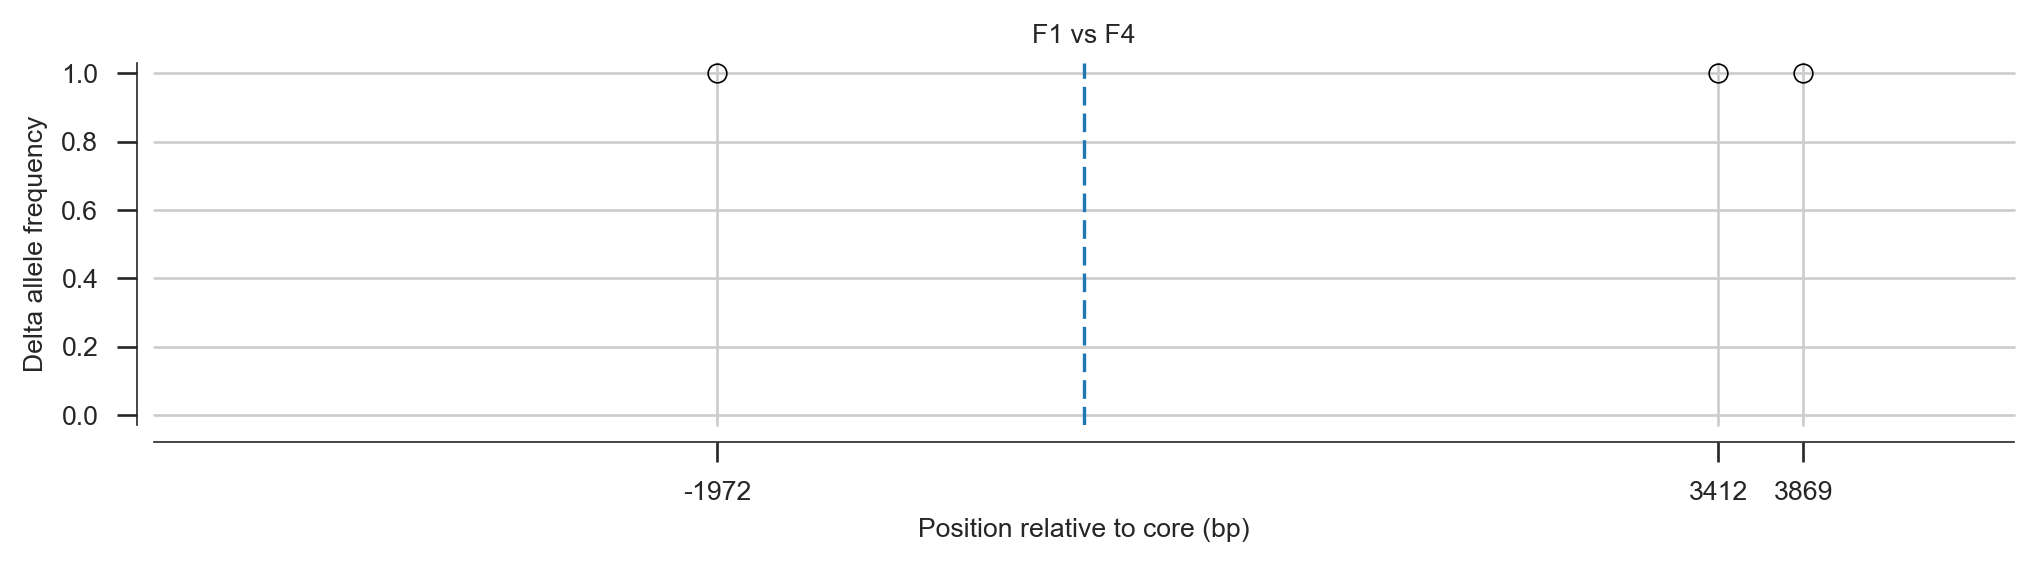

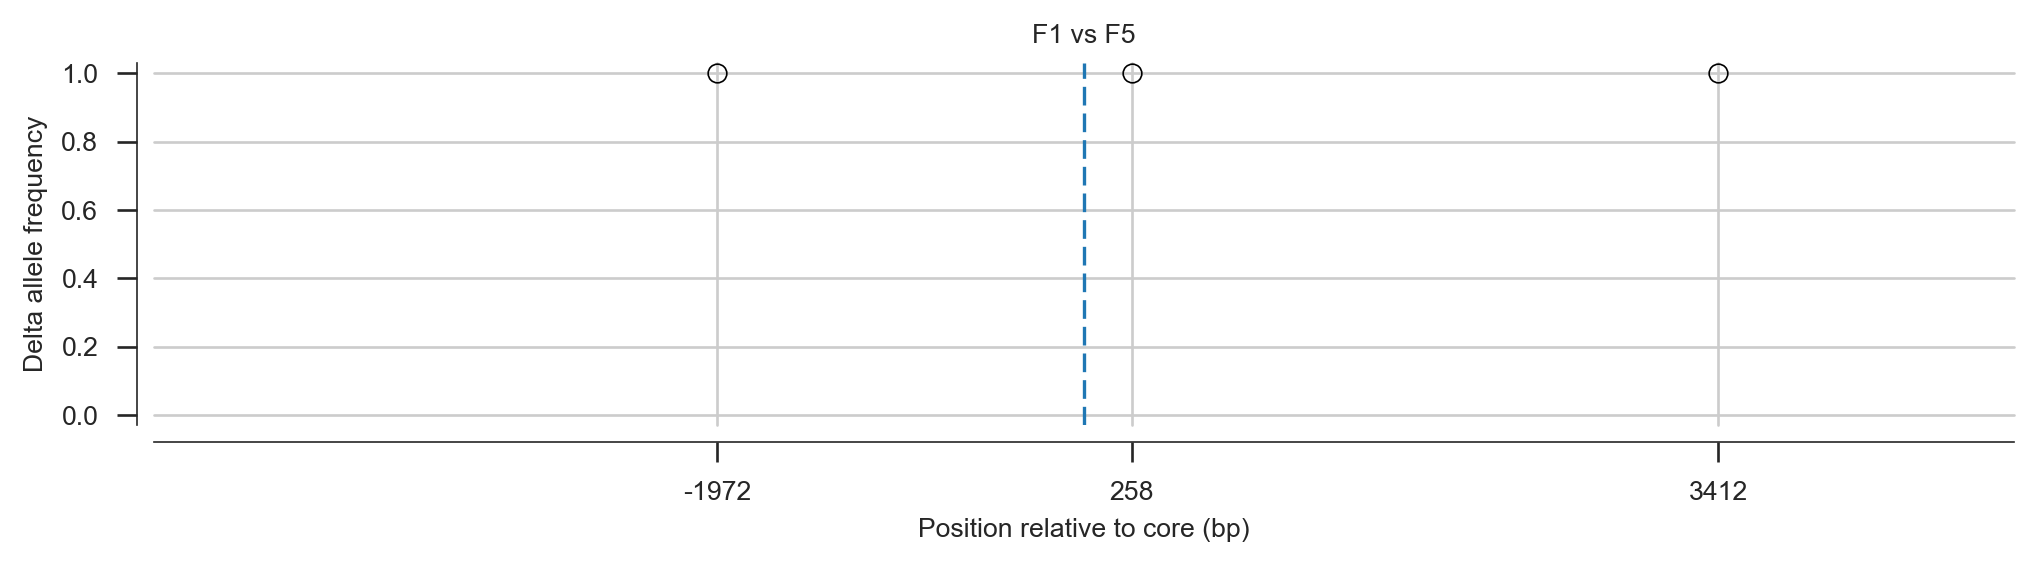

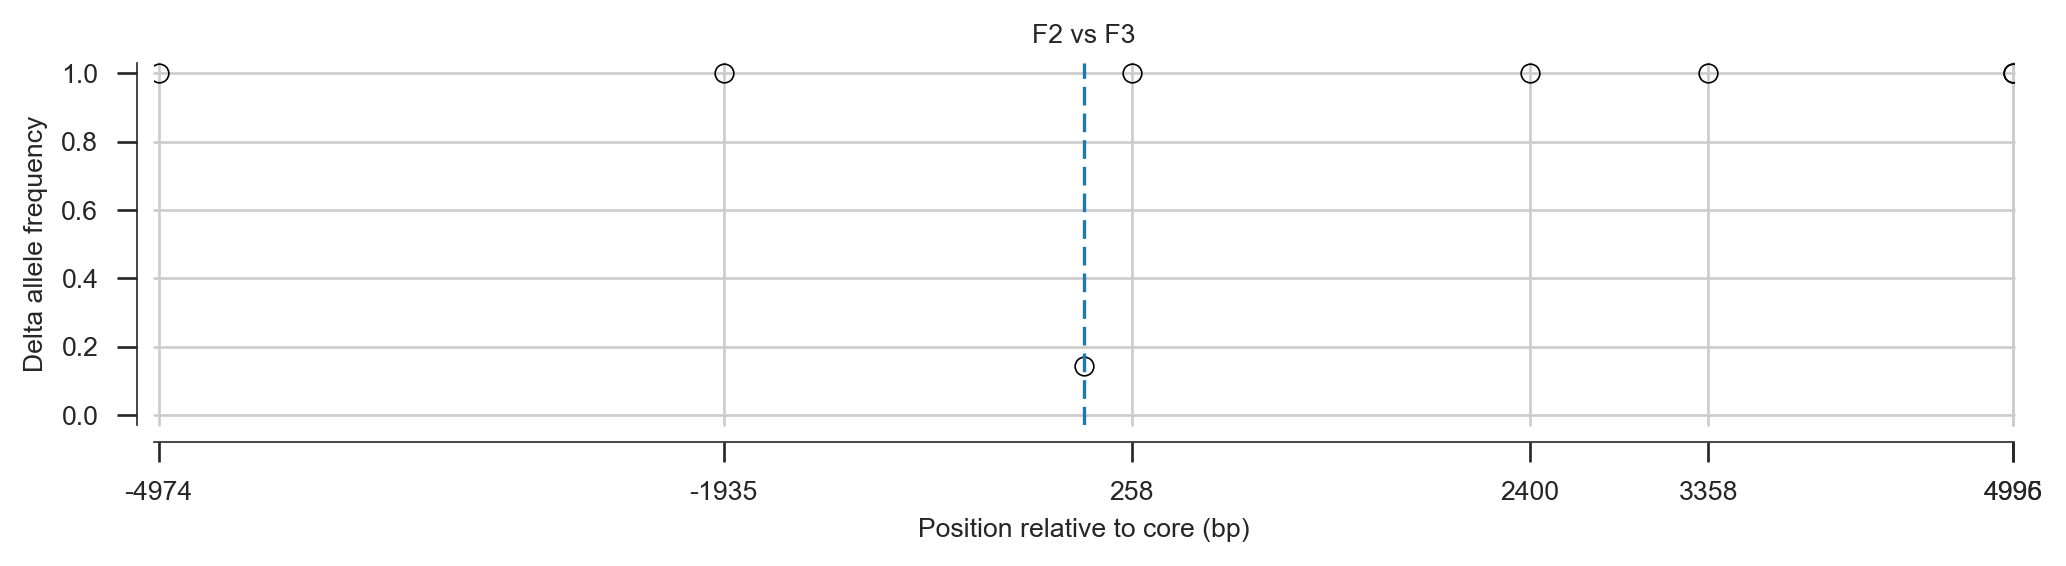

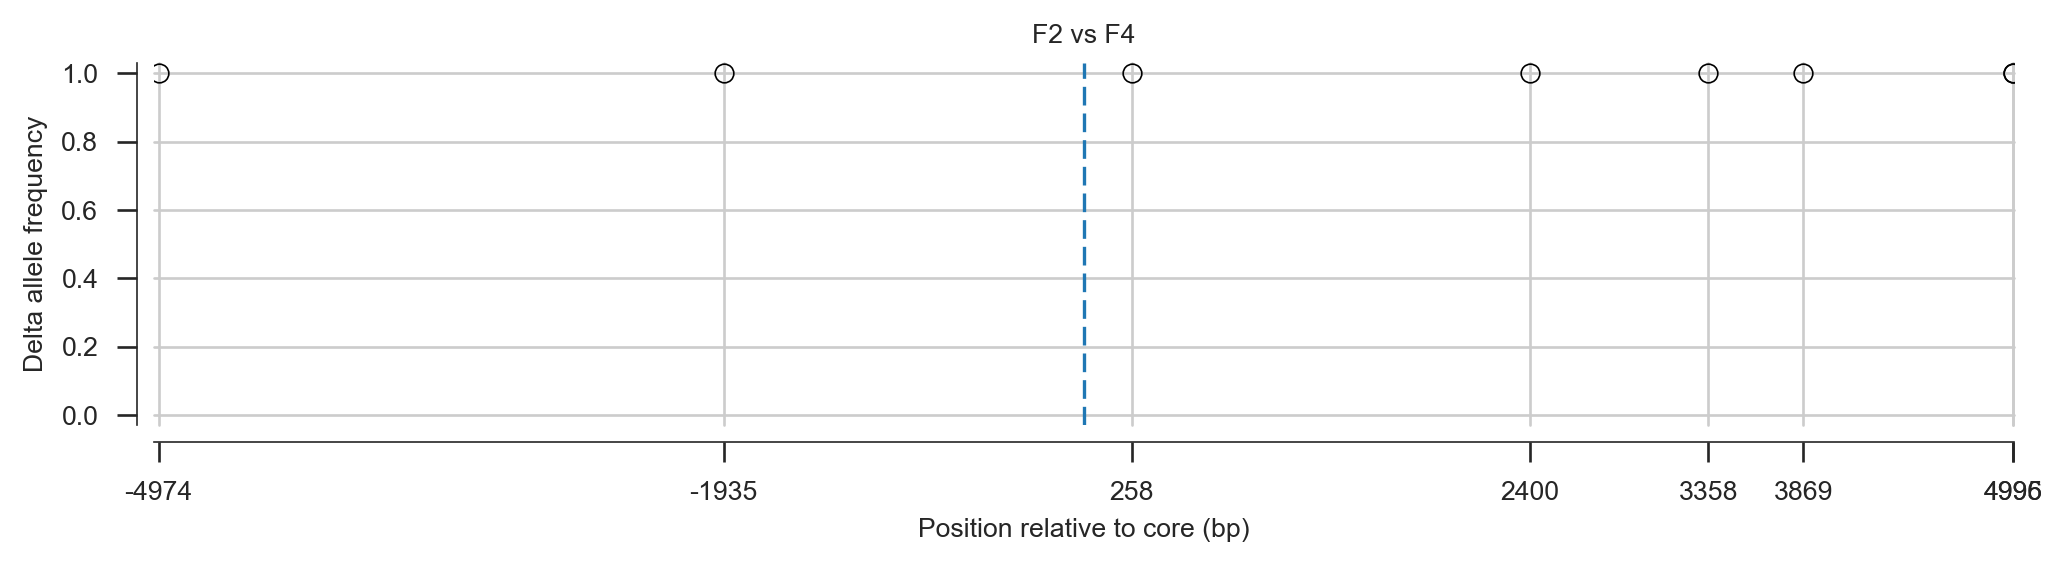

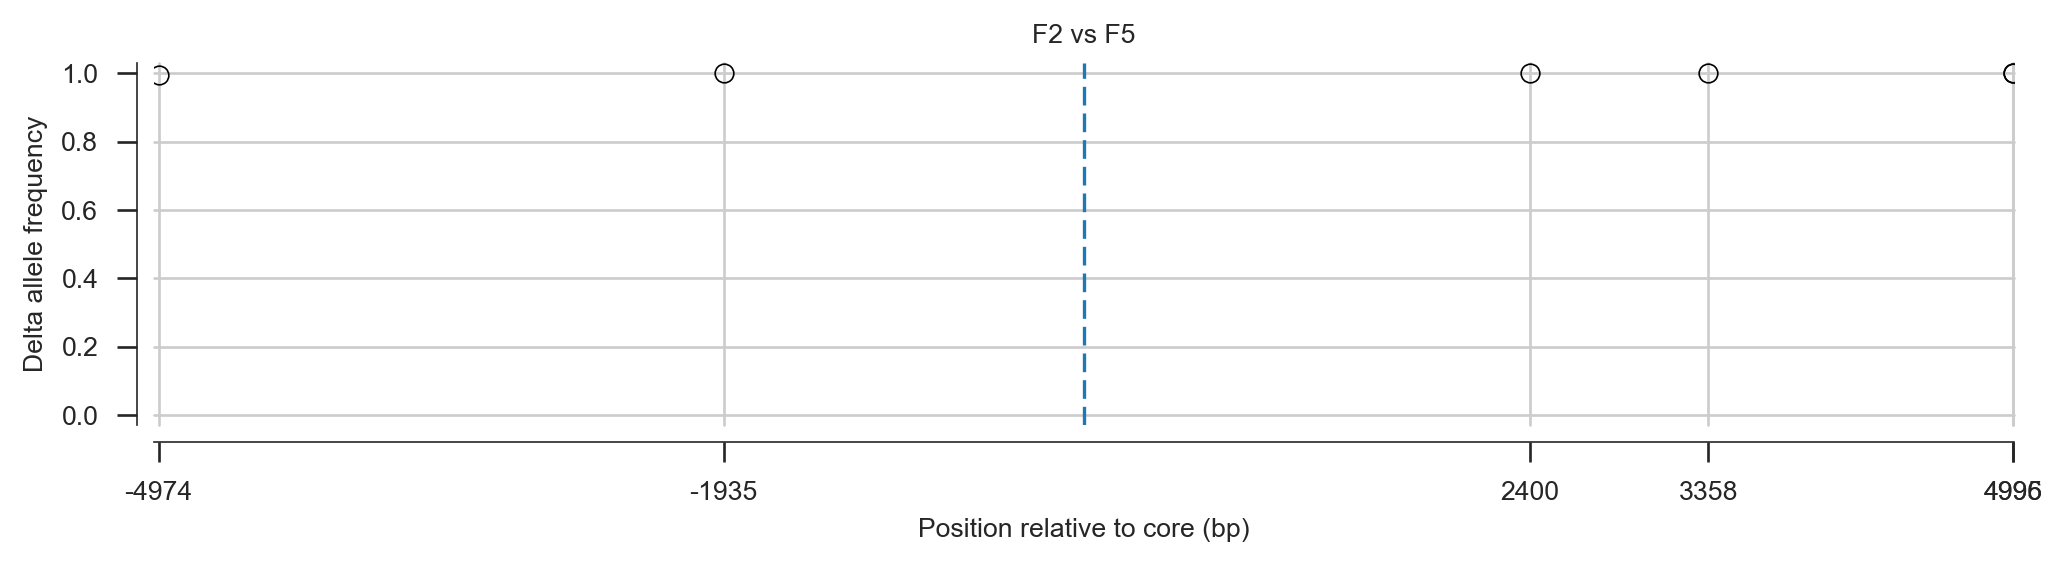

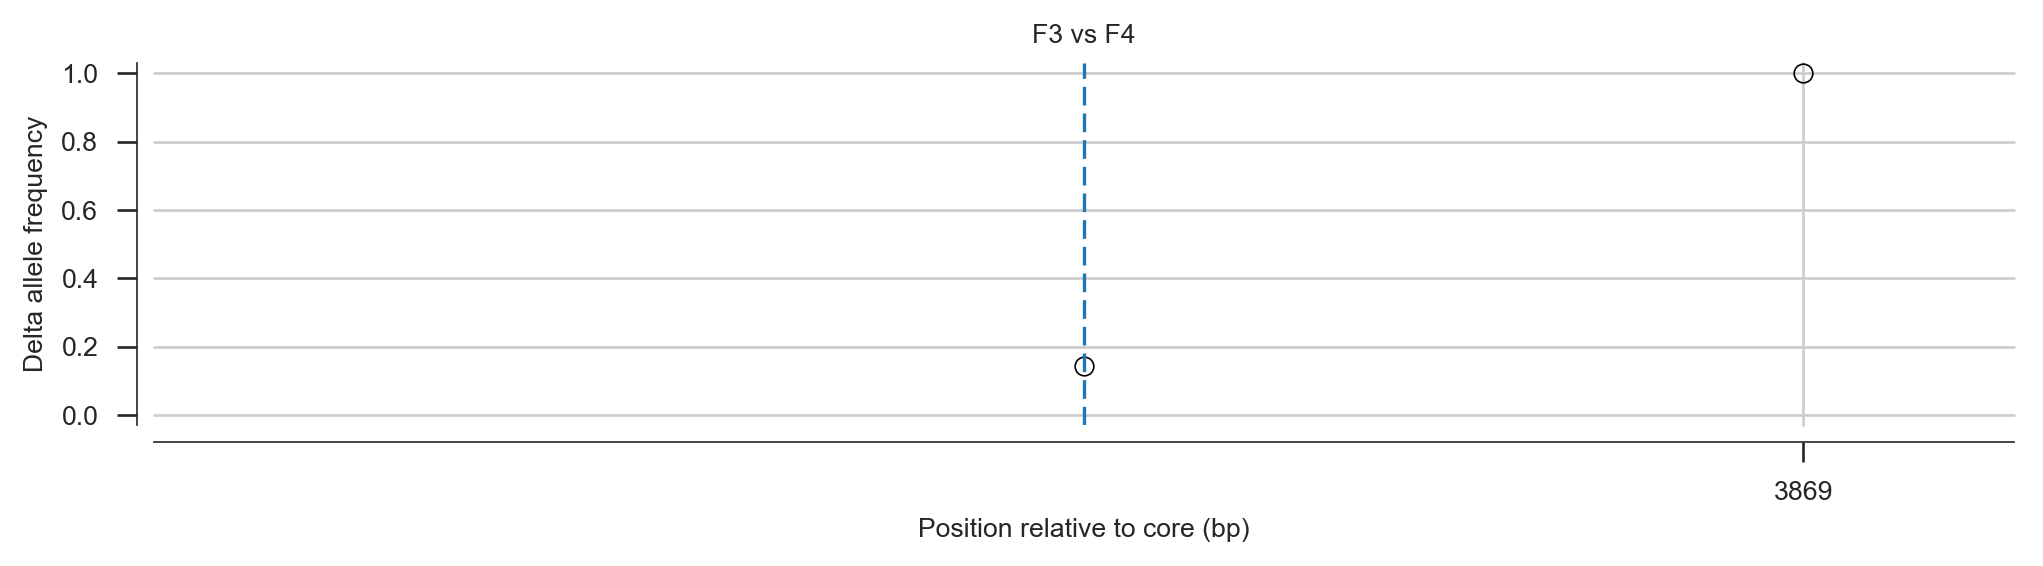

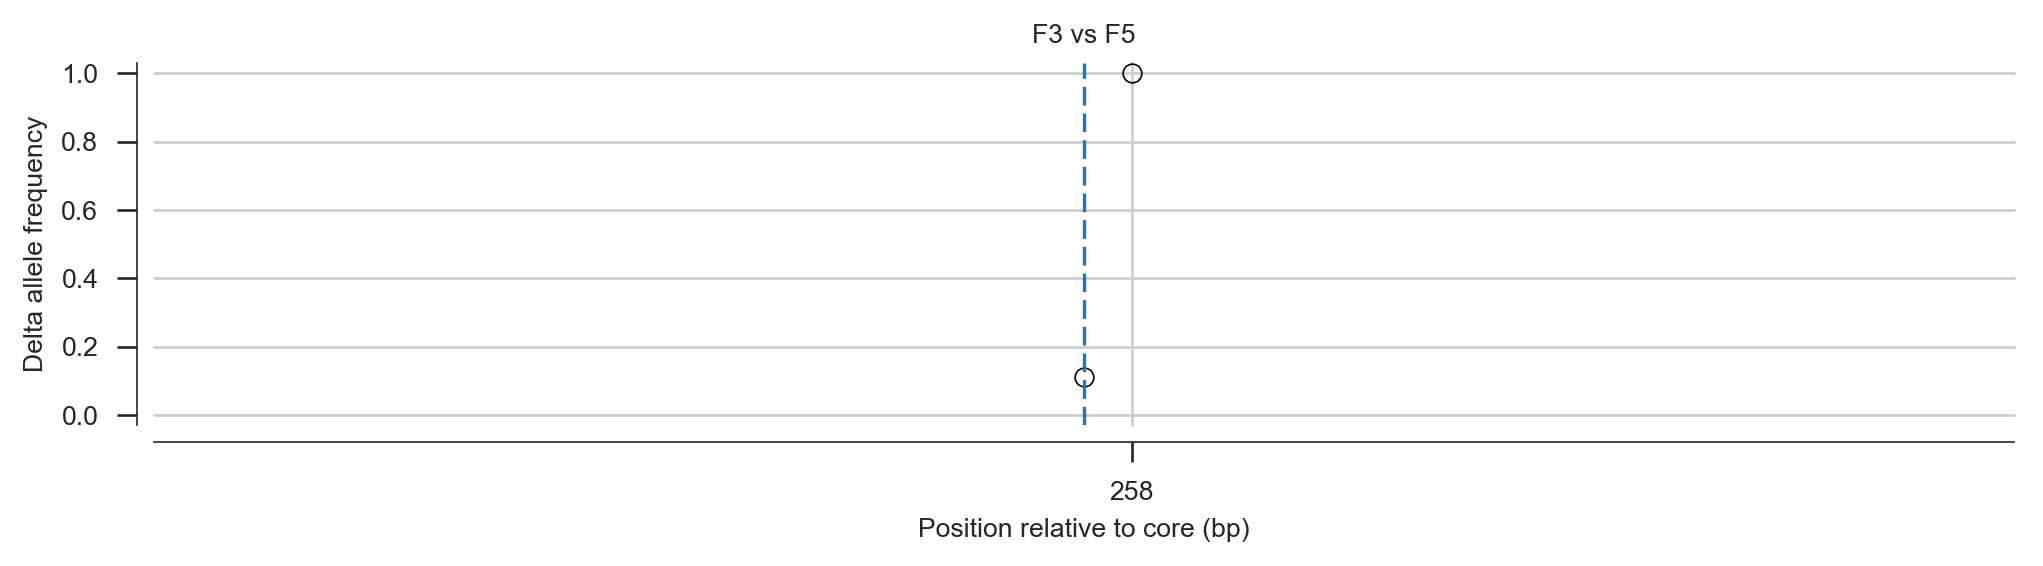

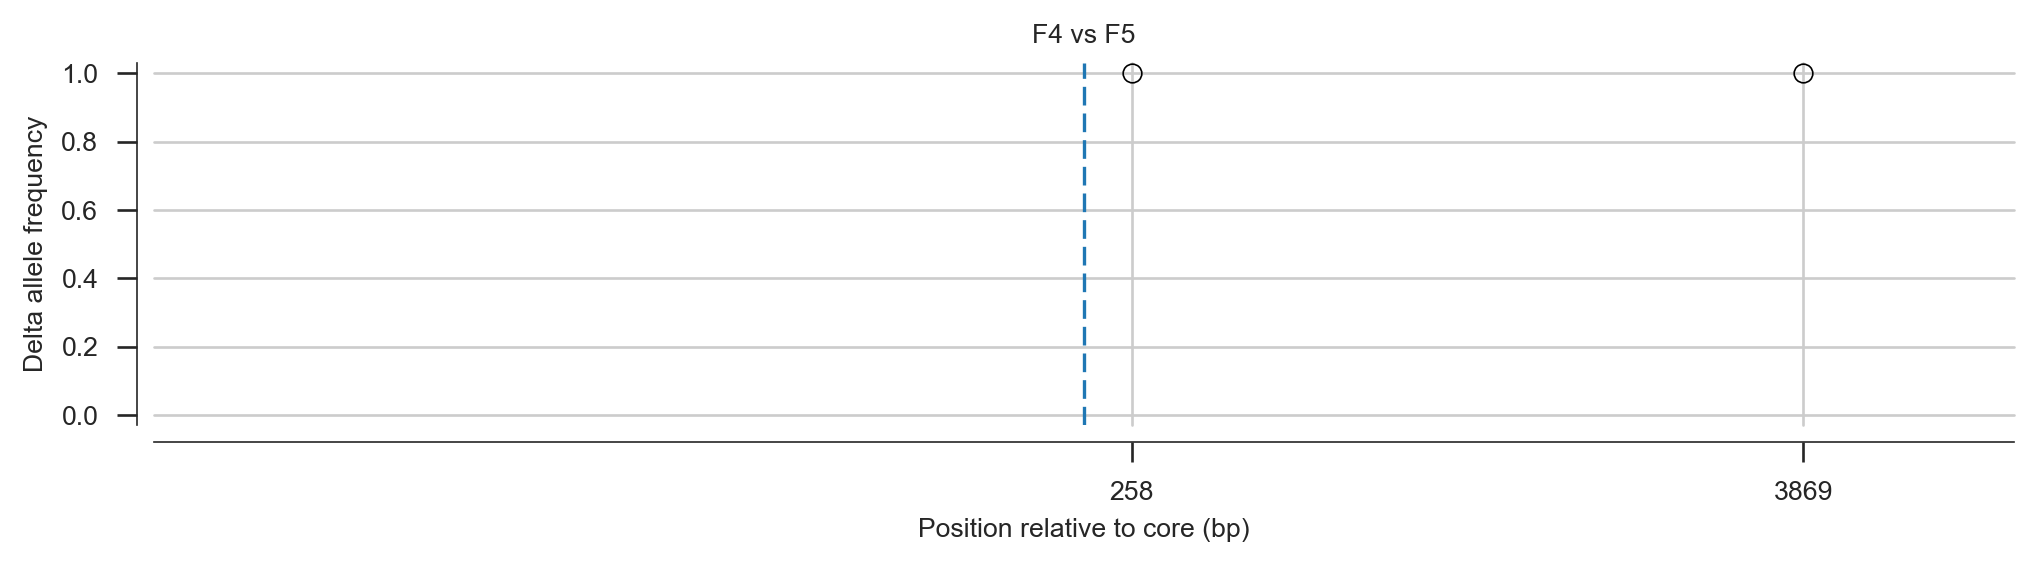

In [40]:
def analyse_995F_core_region():
    core = aa2pos['L995F']
    flank = 5000
    for set1, set2 in itertools.combinations(cluster_labels[:5], 2):
        plot_delta_af(core, flank, set1, set2)
        plt.show()
        
analyse_995F_core_region()

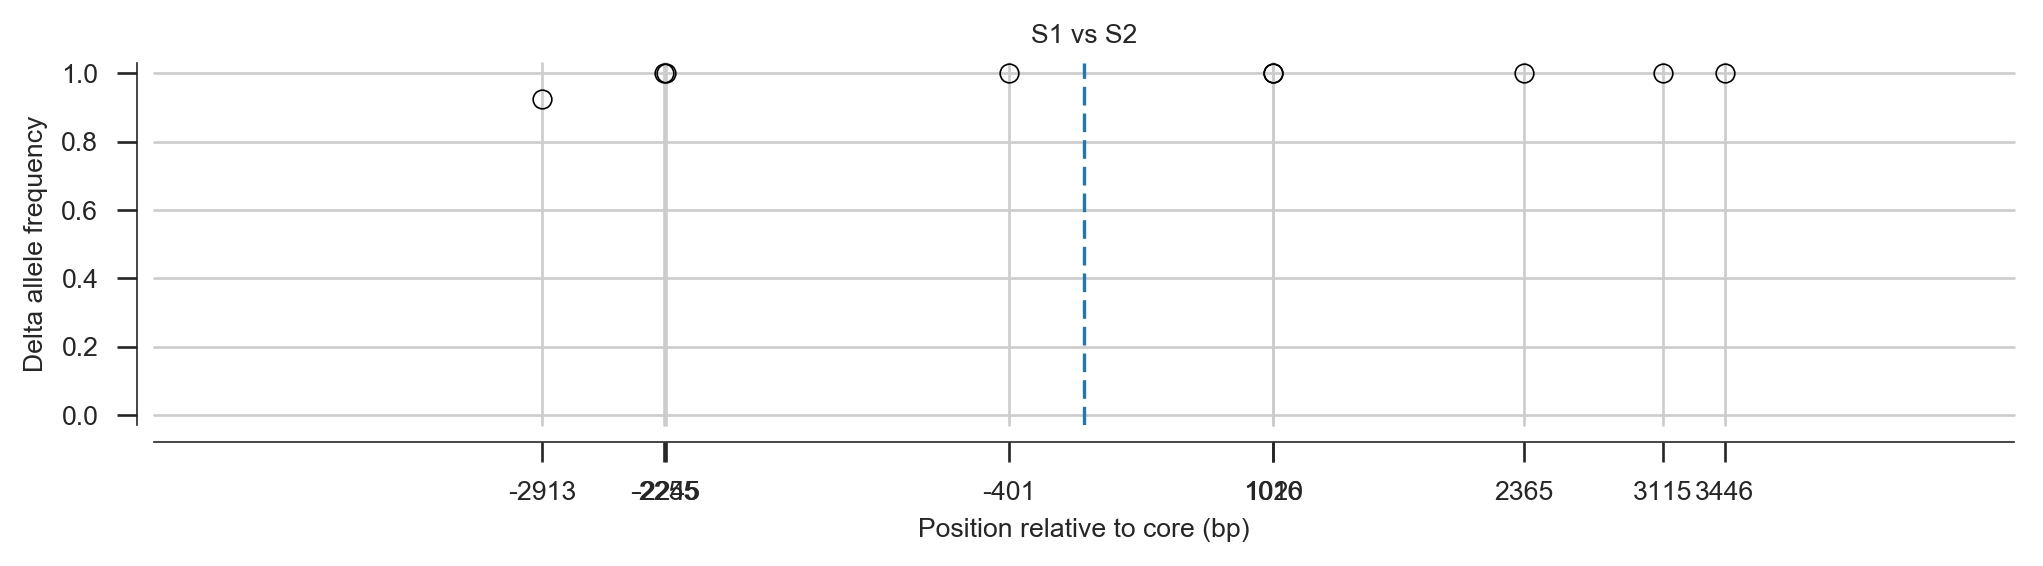

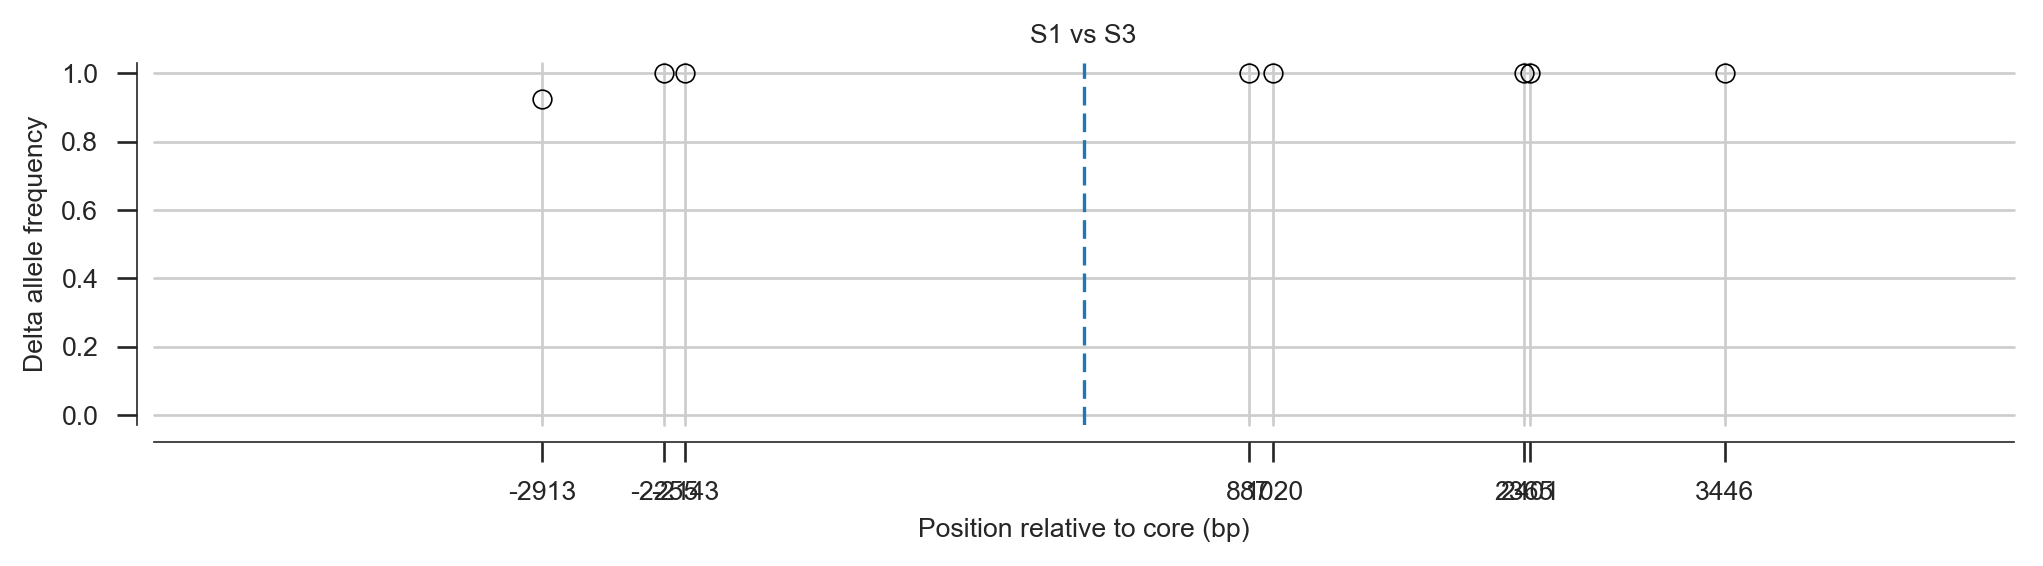

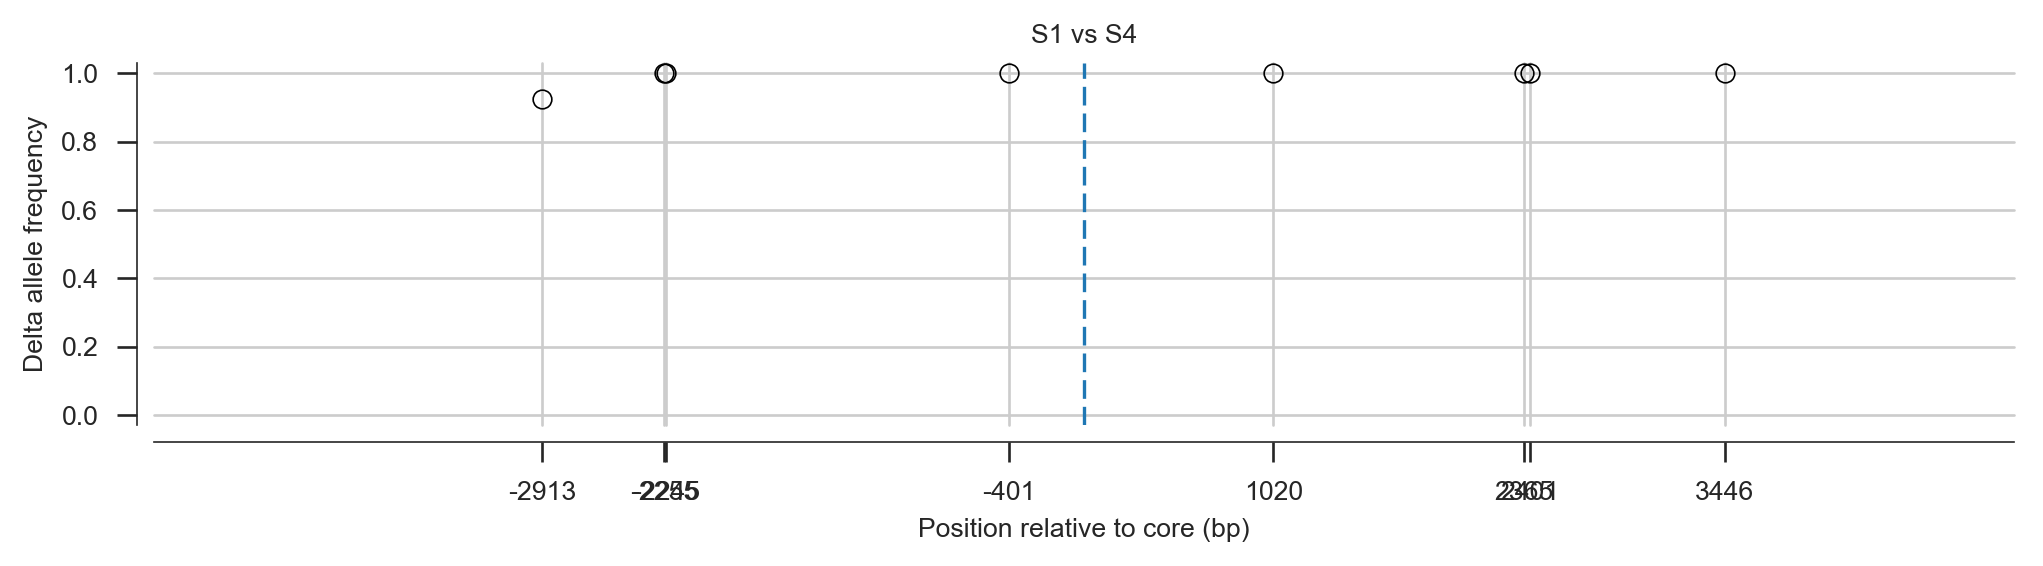

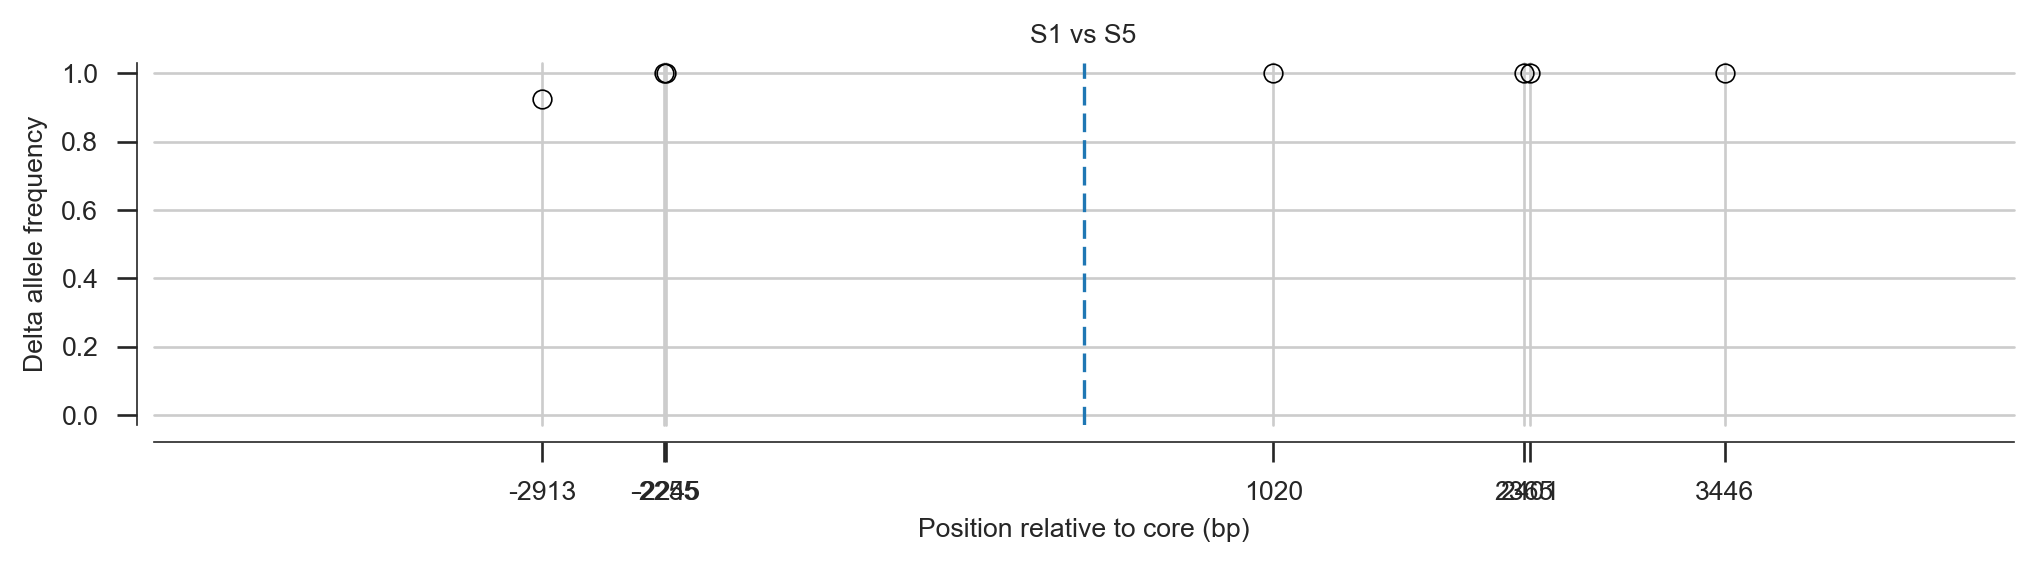

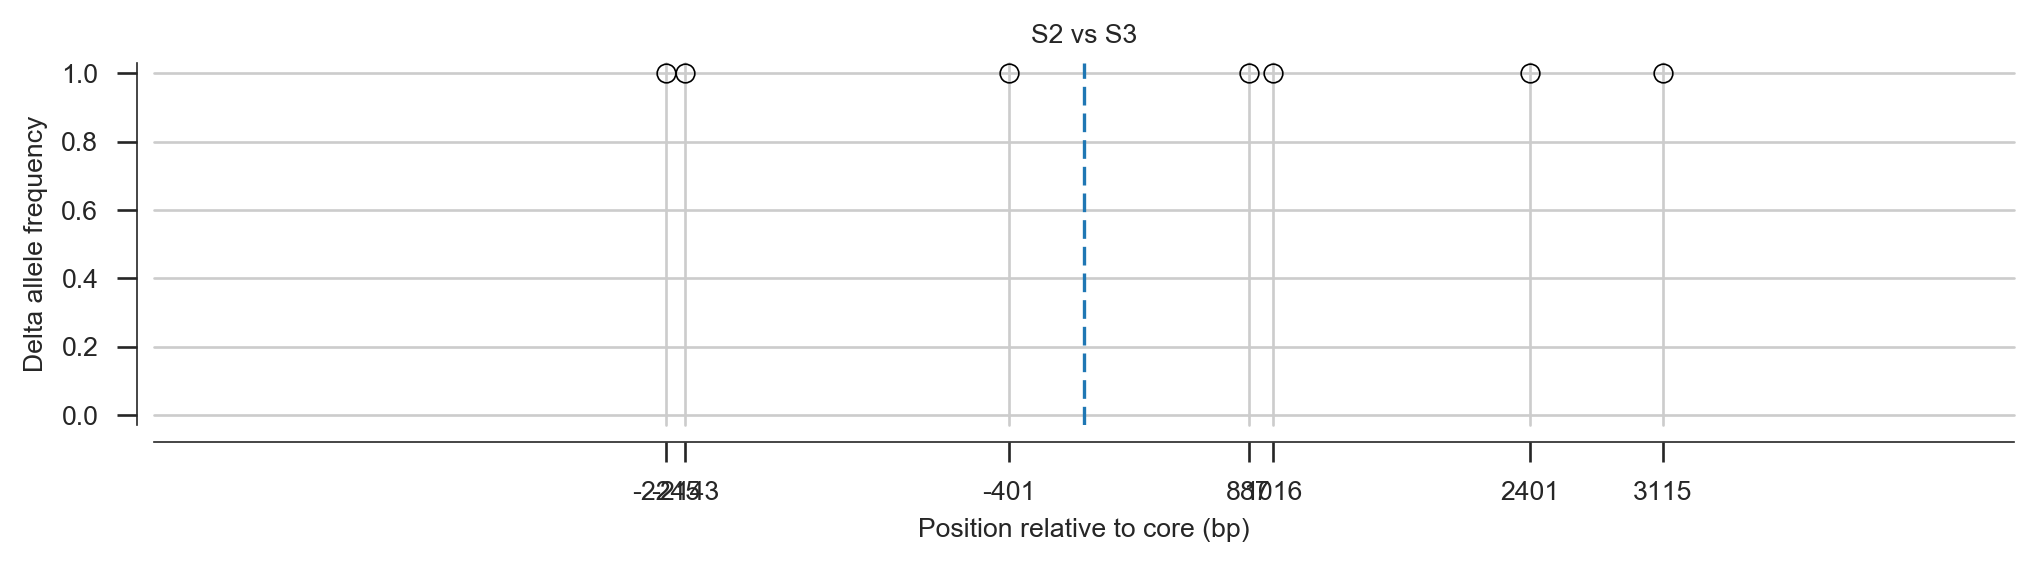

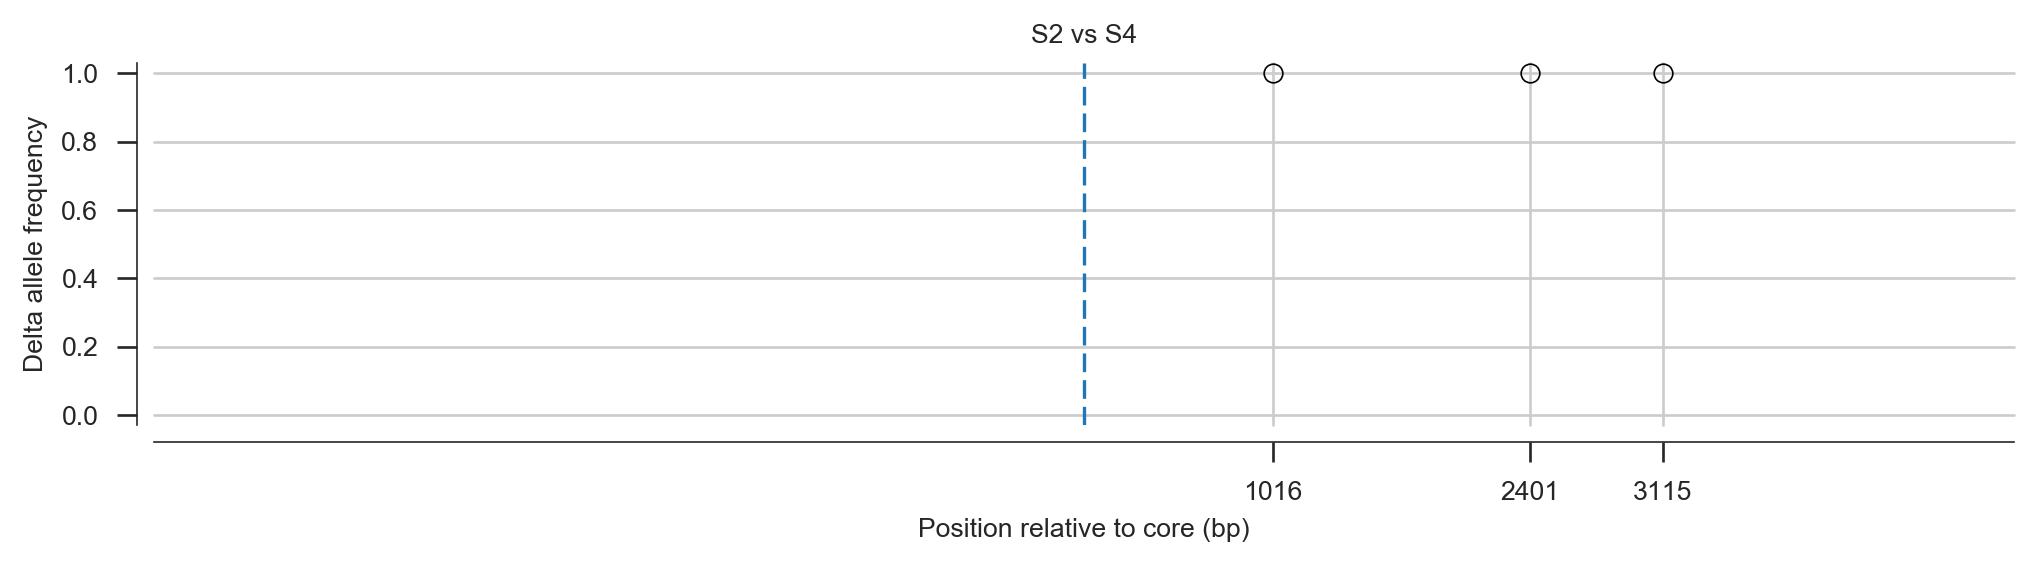

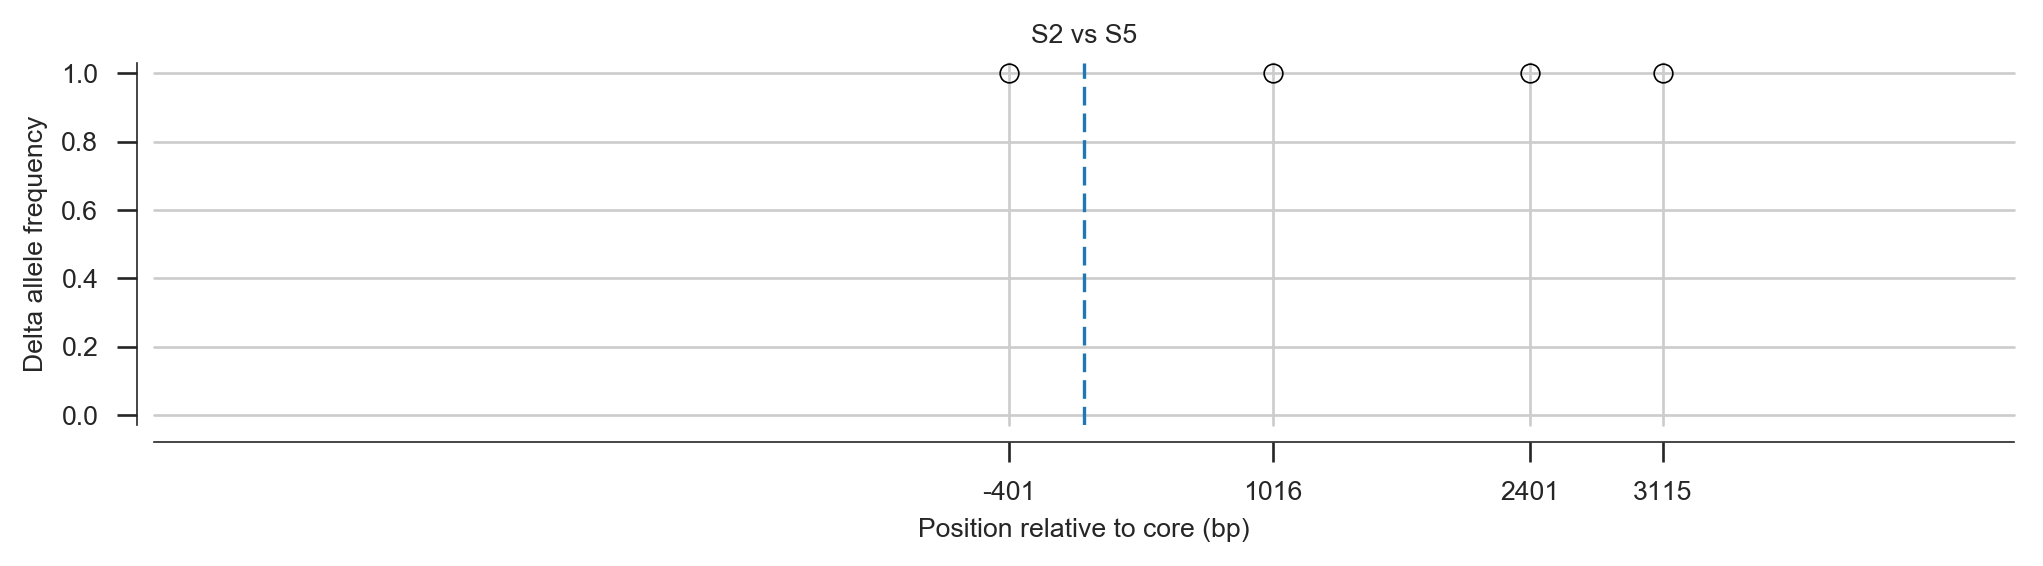

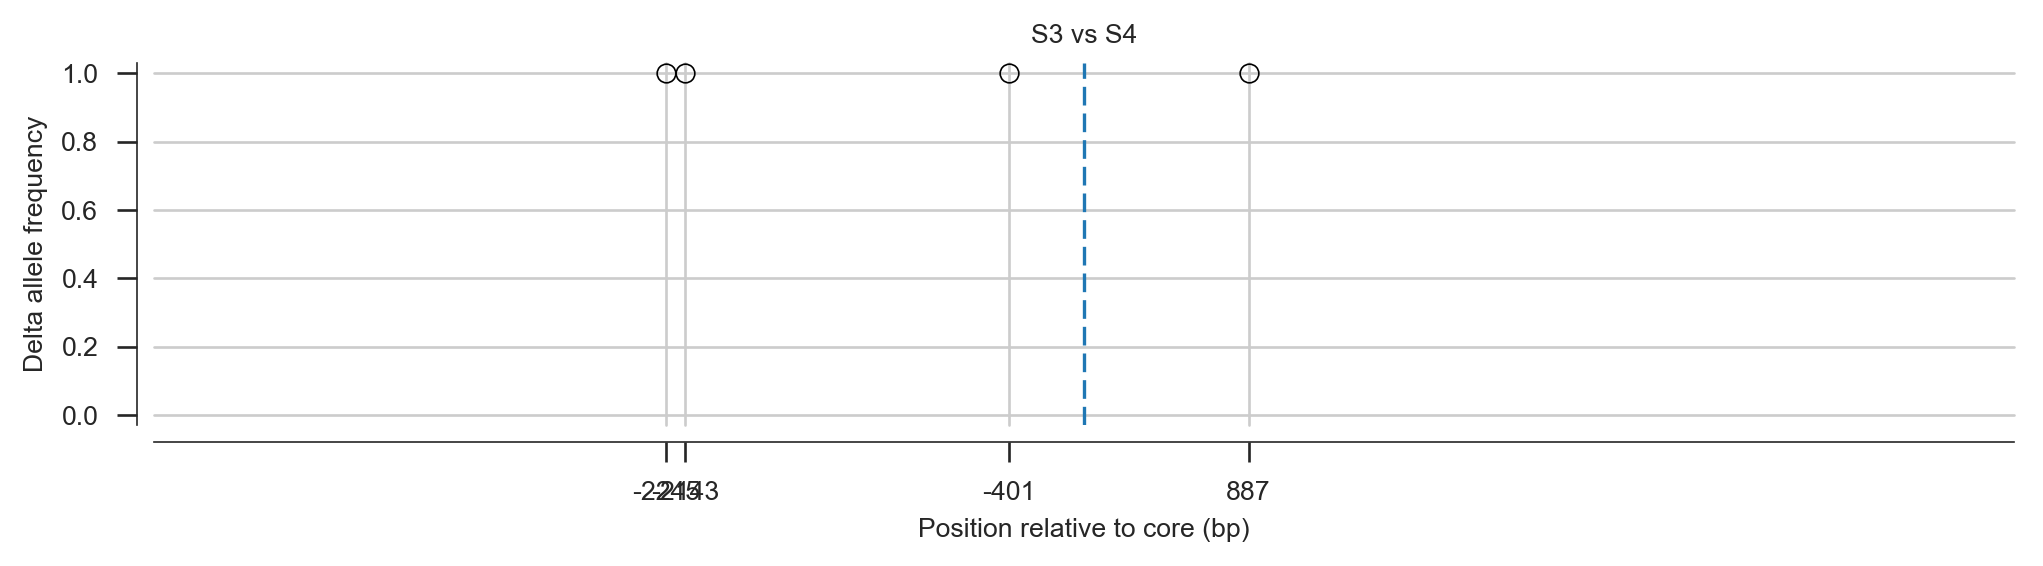

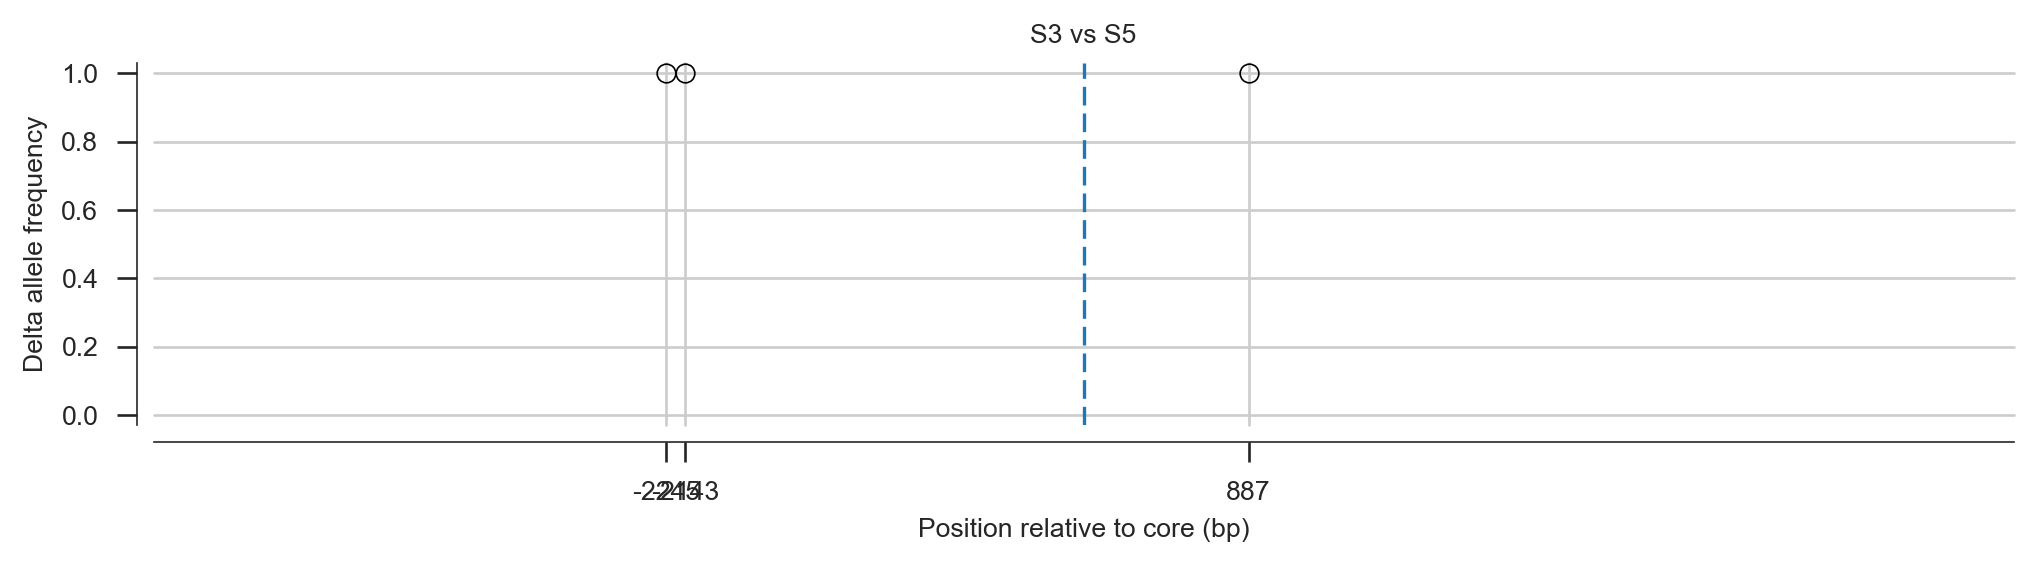

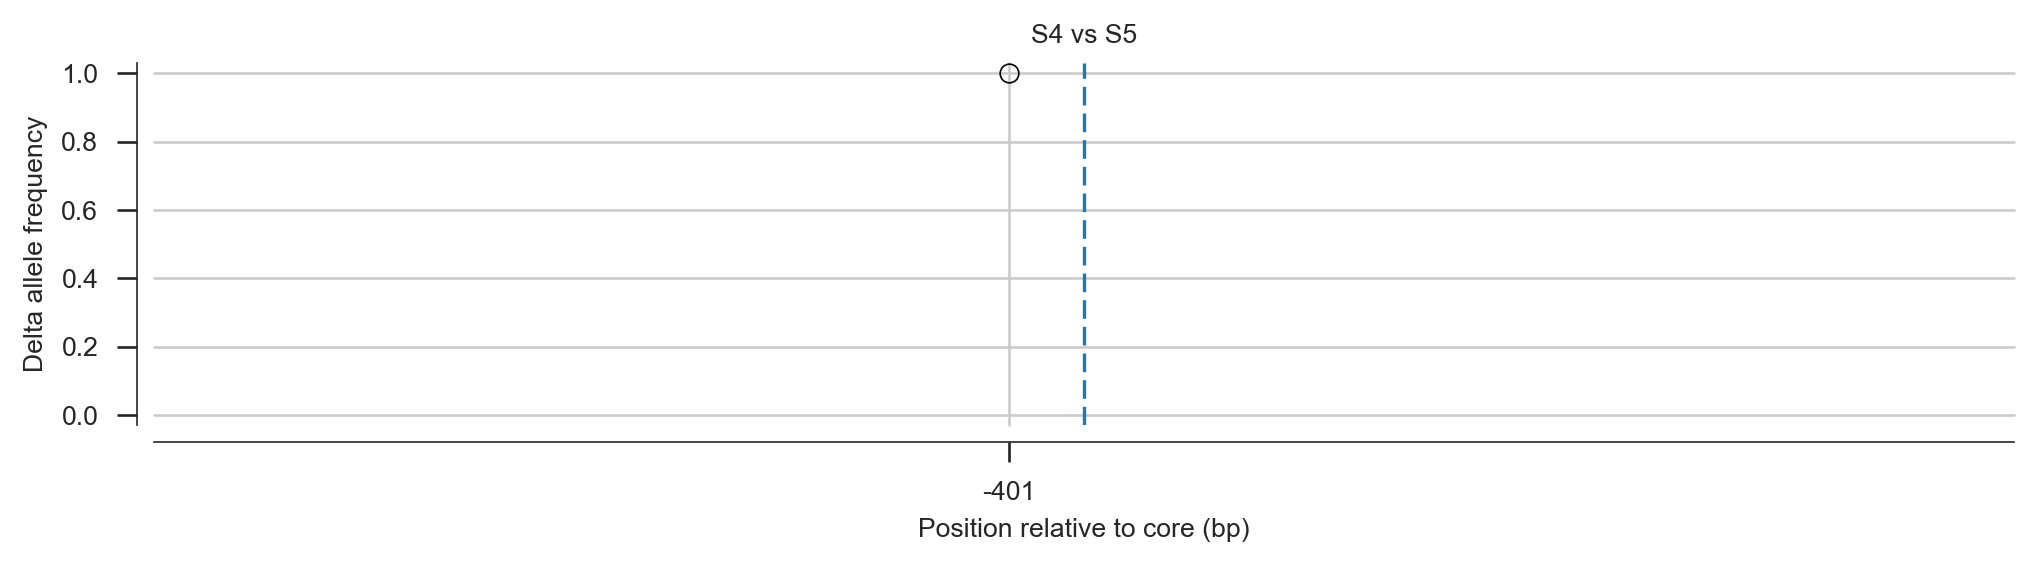

In [41]:
def analyse_995S_core_region():
    core = aa2pos['L995S']
    flank = 5000
    for set1, set2 in itertools.combinations(cluster_labels[5:], 2):
        plot_delta_af(core, flank, set1, set2)
        plt.show()
        
analyse_995S_core_region()

In [42]:
np.count_nonzero(haps[pos.locate_key(aa2pos['I1527T']), :] == 1)

19

In [43]:
np.count_nonzero(haps[pos.locate_key(aa2pos['M490I']), :] == 1)

16

In [44]:
np.count_nonzero(haps[pos.locate_key(aa2pos['M490I']), :] == 2)

2

In [45]:
target_sets = clust_dict.copy()
wt = set(range(haps_ehh.shape[1]))
for s in clust_dict.values():
    wt = wt - s
target_sets['L1'] = set(np.nonzero(haps[pos.locate_key(aa2pos['I1527T']), :] == 1)[0])
target_sets['L2'] = set(np.nonzero(haps[pos.locate_key(aa2pos['M490I']), :] == 1)[0])
wt = wt - target_sets['L1']
wt = wt - target_sets['L2']
target_sets['wt'] = wt

In [46]:
target_labels = sorted(target_sets)
for l in target_labels:
    print(l, len(target_sets[l]))

F1 464
F2 14
F3 42
F4 38
F5 196
L1 19
L2 16
S1 108
S2 79
S3 165
S4 37
S5 36
wt 316


In [47]:
def extract_core_haplotypes(start, stop, min_count=14):

    loc_region = pos_ehh.locate_range(start, stop)
    haps_region = haps_ehh[loc_region]
    ret = list()

    distinct_sets = haps_region.distinct()
    wt_ix = 0
    for s in distinct_sets:
        isecs = [len(s.intersection(target_sets[l])) for l in target_labels]
        label = target_labels[np.argmax(isecs)]
        if label == 'wt':
            label = 'wt' + str(wt_ix)
            wt_ix += 1
        if len(s) >= min_count:
            ret.append((label, s))
            print(label, len(s), *['%s:%s/%s (%.1f%%)' % (l, len(s.intersection(o)), len(o), len(s.intersection(o)) * 100 / len(o)) 
                                   for l, o in sorted(target_sets.items())
                                   if s.intersection(o)])
            
    return ret

In [48]:
start = aa2pos['L995S'] - 402
stop = aa2pos['L995S'] + 3870
core_haps = extract_core_haplotypes(start, stop, min_count=14)

F1 468 F1:459/464 (98.9%) wt:9/316 (2.8%)
F5 188 F5:187/196 (95.4%) wt:1/316 (0.3%)
S3 153 S3:153/165 (92.7%)
S1 108 S1:108/108 (100.0%)
S2 79 S2:79/79 (100.0%)
wt0 51 wt:51/316 (16.1%)
F4 51 F4:38/38 (100.0%) wt:13/316 (4.1%)
wt1 38 wt:38/316 (12.0%)
wt2 37 wt:37/316 (11.7%)
S4 37 S4:37/37 (100.0%)
F3 37 F3:36/42 (85.7%) wt:1/316 (0.3%)
S5 36 S5:36/36 (100.0%)
wt3 23 wt:23/316 (7.3%)
L2 21 L2:16/16 (100.0%) wt:5/316 (1.6%)
L1 20 L1:18/19 (94.7%) wt:2/316 (0.6%)
wt4 20 F1:3/464 (0.6%) wt:17/316 (5.4%)
wt5 20 F3:6/42 (14.3%) wt:14/316 (4.4%)
wt6 20 F5:4/196 (2.0%) wt:16/316 (5.1%)
F2 14 F2:14/14 (100.0%)


## EHH decay plots

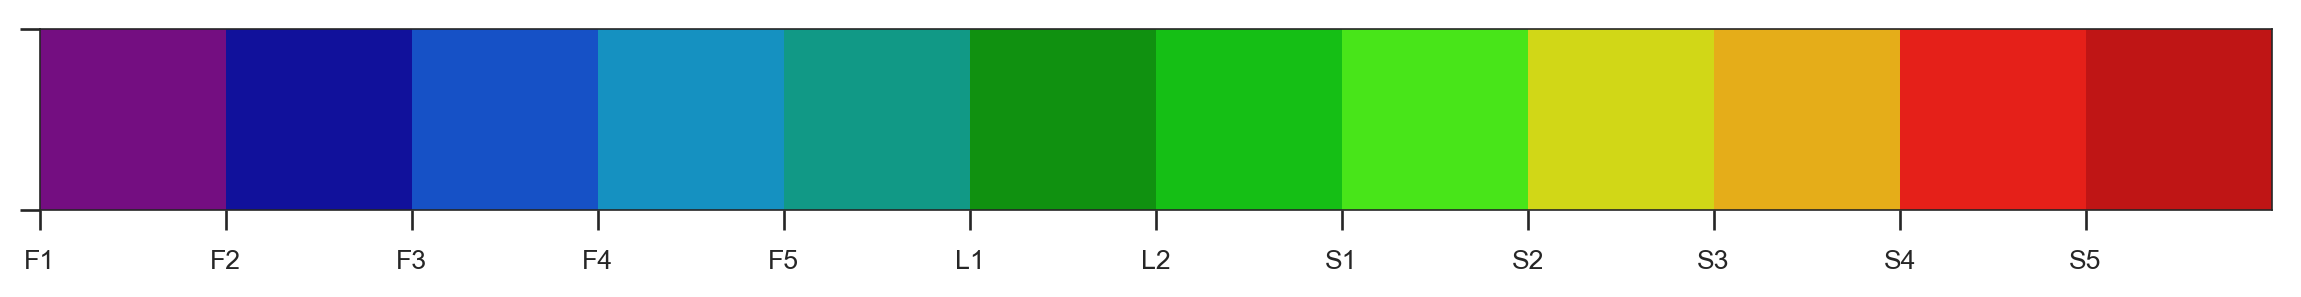

In [49]:
cluster_palette = sns.color_palette('nipy_spectral', n_colors=len(target_labels) - 1, desat=0.8)
sns.palplot(cluster_palette)
plt.gca().set_xticklabels(target_labels)
cluster_colors = dict(zip(target_labels, cluster_palette))  # don't include wt

In [50]:
sns.set_style('white')
sns.set_style('ticks')

In [51]:
def plot_ehh_decay(core, core_haps, flank=1000000, ax=None, cluster_colors=cluster_colors):
    
    loc_right = pos_ehh.locate_range(core, core + flank)
    haps_right = haps_ehh[loc_right]
    pos_right = pos_ehh[loc_right]

    loc_left = pos_ehh.locate_range(core - flank, core)
    haps_left = haps_ehh[loc_left]
    pos_left = pos_ehh[loc_left]
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2.4))
        sns.despine(ax=ax, offset=5)

    labels = set()
    for l, s in core_haps:
        labels.add(l)
        
        if l in cluster_colors:
            color = cluster_colors[l]
            lw = 2
        else:
            # TODO
            color = 'k'
            lw = .5
        haps_right_core = haps_right.take(sorted(s), axis=1)
        haps_left_core = haps_left.take(sorted(s), axis=1)
        ehh_decay_right = allel.ehh_decay(haps_right_core)
        ehh_decay_left = allel.ehh_decay(haps_left_core[::-1])

        ax.plot(pos_right, ehh_decay_right, color=color, lw=lw)
        ax.plot(pos_left, ehh_decay_left[::-1], color=color, lw=lw)
        
    ax.set_xlim(core - flank, core + flank)
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_xticklabels(['%.1f' % (t/1e6) for t in ax.get_xticks()])
    ax.set_ylim(0, 1.02)
    ax.set_ylabel('EHH')
#     ax.grid(axis='y')
    
    handles = []
    for l in sorted(labels):
        if l in cluster_colors:
            color = cluster_colors[l]
            lw = 2
            label = l
            handles.append(plt.Line2D([0, 0], [0, 0], color=color, lw=lw, label=l))
    color = 'k'
    lw = .5
    handles.append(plt.Line2D([0, 0], [0, 0], color=color, lw=lw, label='wt'))
        
    legend = ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper right', labelspacing=.3,
                       frameon=False, framealpha=1, title='Core haplotype')
    plt.setp(legend.get_title(), fontsize=base_font_size)

    if fig:
        fig.tight_layout()


In [52]:
for l, s in core_haps:
    print(l, len(s))

F1 468
F5 188
S3 153
S1 108
S2 79
wt0 51
F4 51
wt1 38
wt2 37
S4 37
F3 37
S5 36
wt3 23
L2 21
L1 20
wt4 20
wt5 20
wt6 20
F2 14


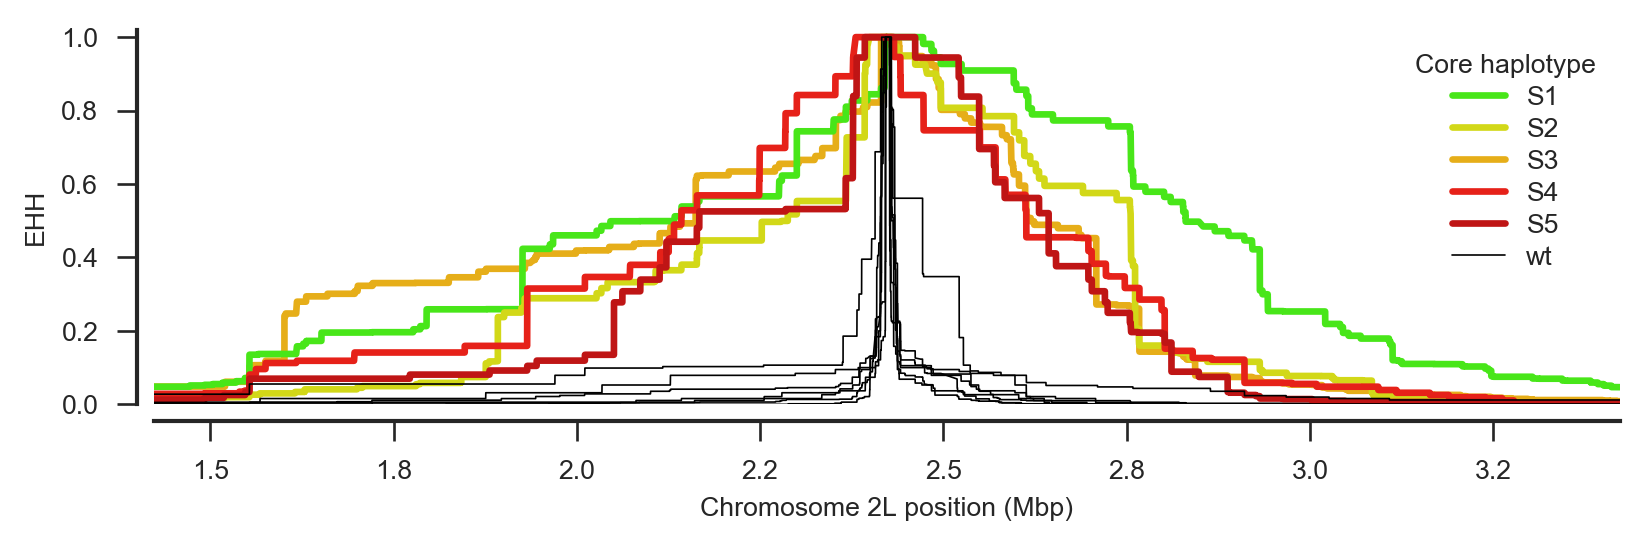

In [53]:
plot_ehh_decay(aa2pos['L995S'], [(l, s) for l, s in core_haps if l.startswith('S') or l.startswith('wt')])

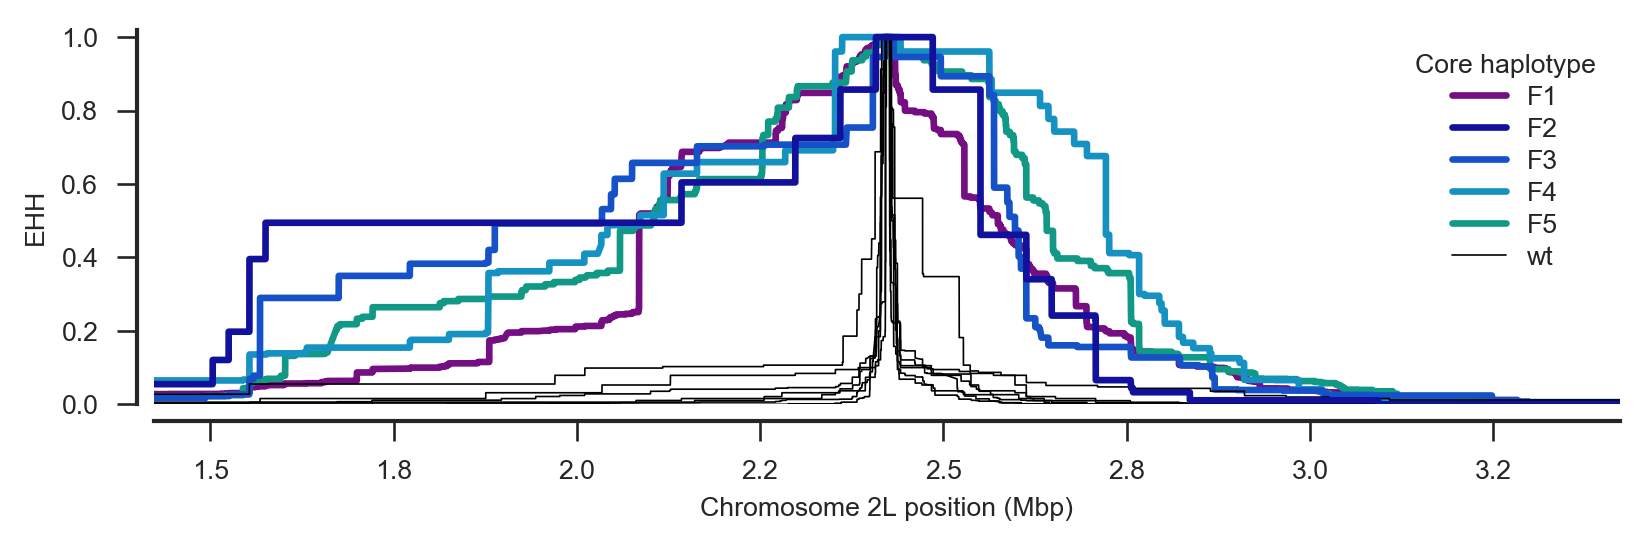

In [54]:
plot_ehh_decay(aa2pos['L995S'], [(l, s) for l, s in core_haps if l.startswith('F') or l.startswith('wt')])

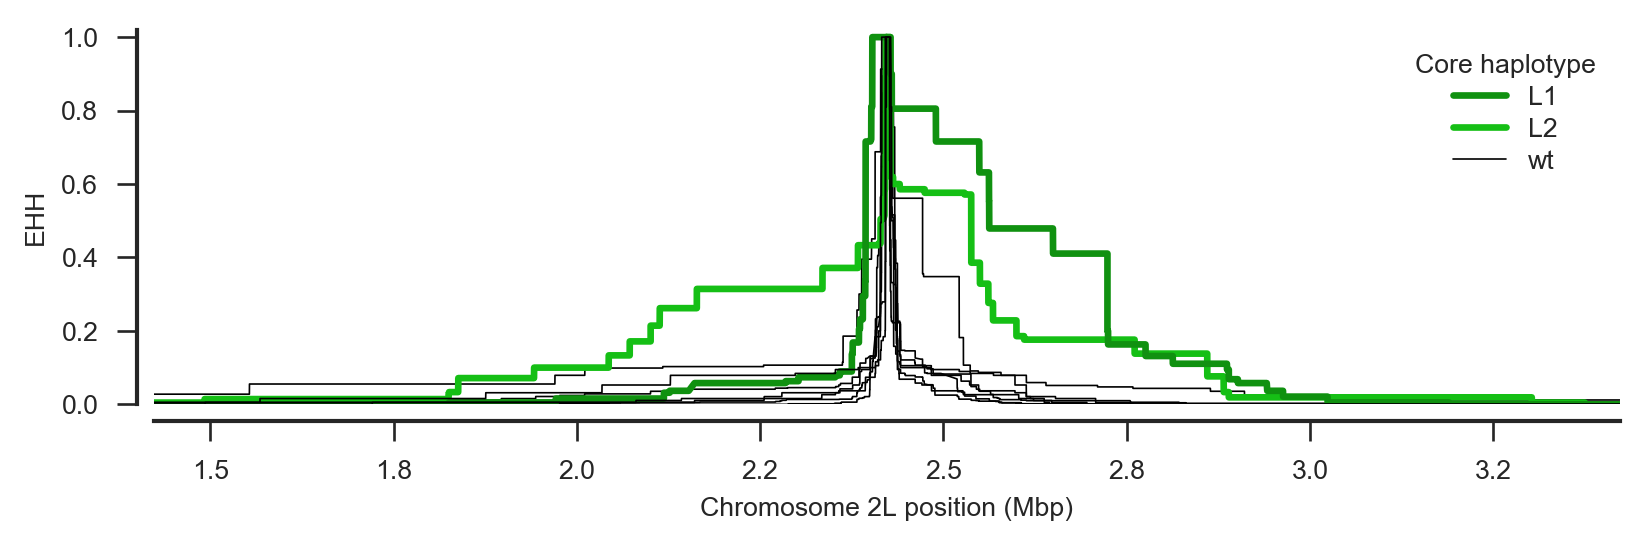

In [55]:
plot_ehh_decay(aa2pos['L995S'], [(l, s) for l, s in core_haps if l.startswith('L') or l.startswith('wt')])

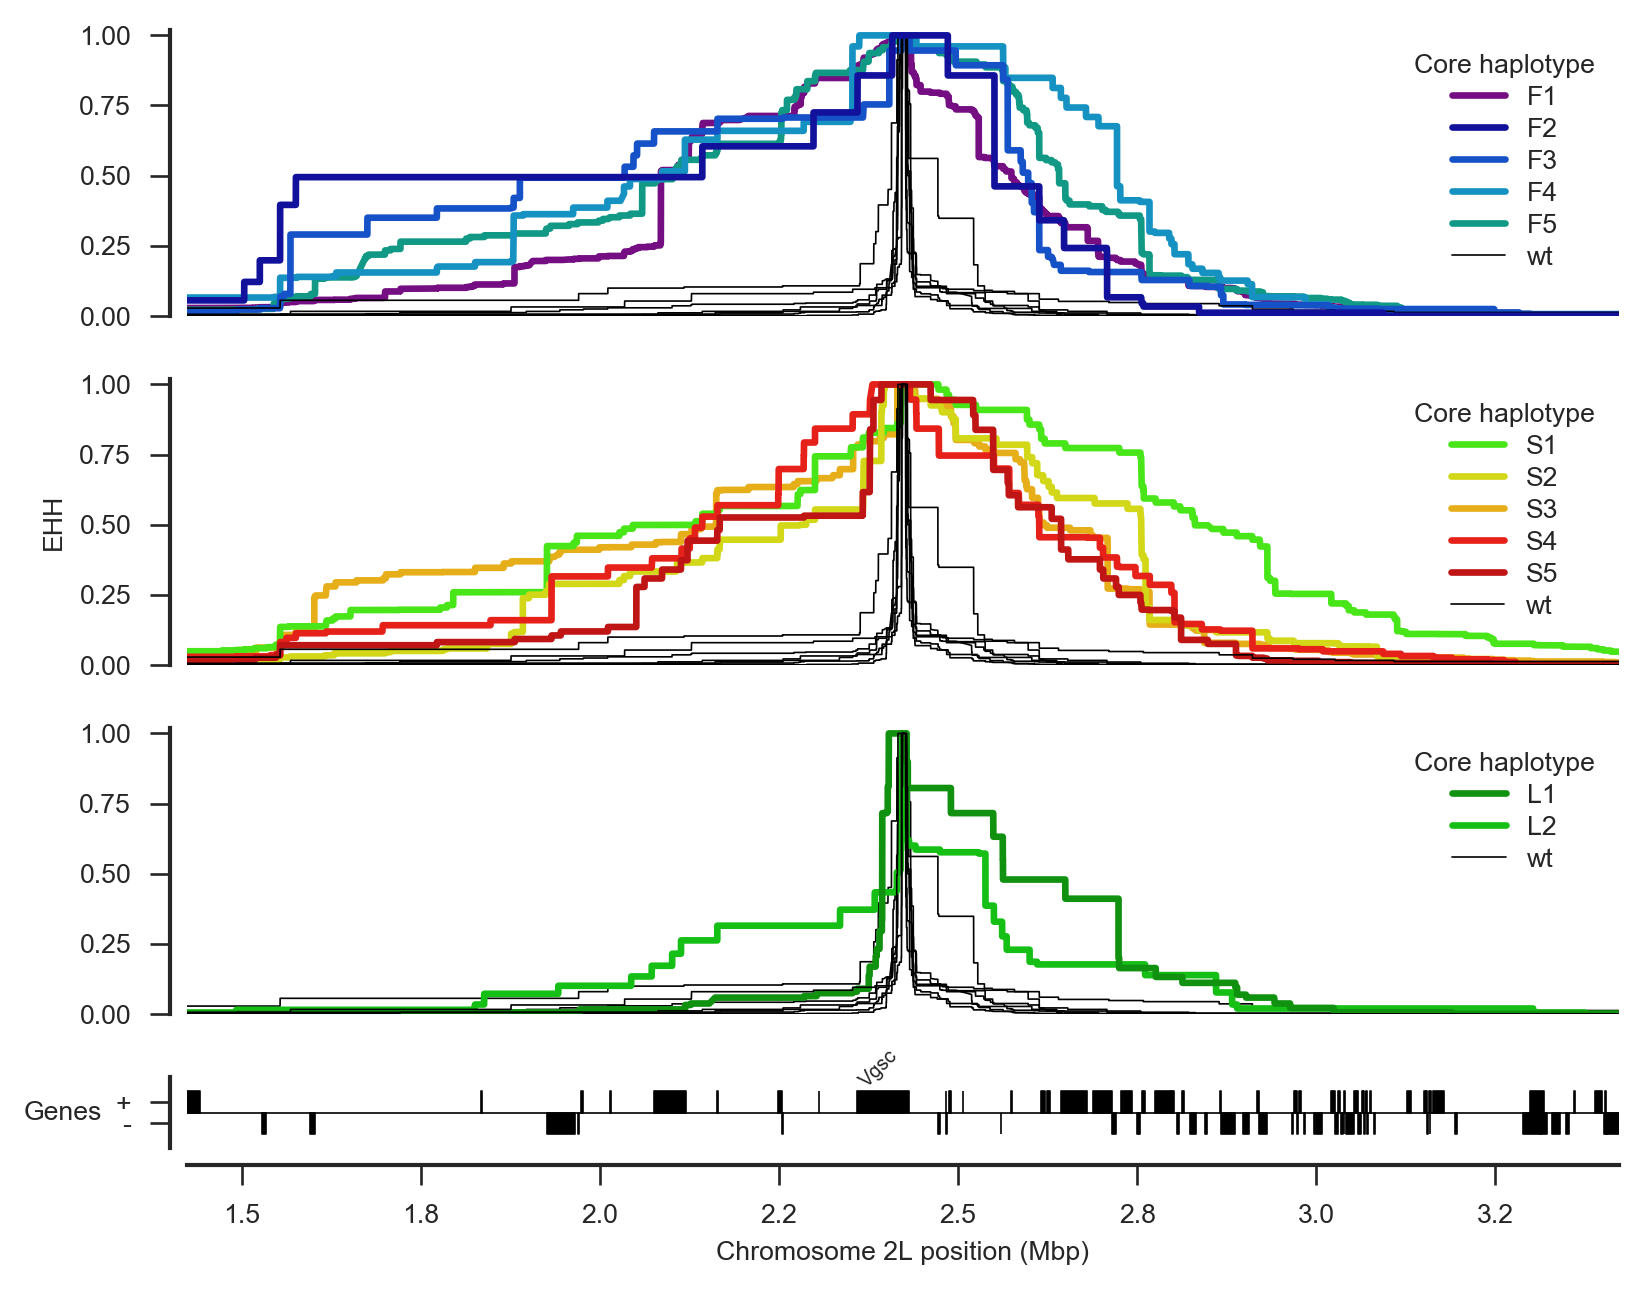

In [56]:
def fig_kdr_ehh_decay(figsize=(7, 5.5), fn=None, save_dpi=150):
    core = aa2pos['L995S']
    flank = 1000000

    fig = plt.figure(figsize=figsize)
    gs = mpl.gridspec.GridSpec(4, 1, height_ratios=[4, 4, 4, 1])

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, [(l, s) for l, s in core_haps if l.startswith('F') or l.startswith('wt')], ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, [(l, s) for l, s in core_haps if l.startswith('S') or l.startswith('wt')], ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('EHH')

    ax = fig.add_subplot(gs[2])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, [(l, s) for l, s in core_haps if l.startswith('L') or l.startswith('wt')], ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = fig.add_subplot(gs[3])
    sns.despine(ax=ax, offset=5)
    plot_genes(phase1_ar3.genome_fn, phase1_ar3.geneset_agamp42_fn, ax=ax,
               chrom='2L', start=core-flank, stop=core+flank, labels=gene_labels, label=True, label_unnamed=False)    
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_xticklabels(['%.1f' % (t/1e6) for t in ax.get_xticks()])
    ax.set_ylabel('Genes')
    
    fig.tight_layout()
    if fn:
        fig.savefig(fn, bbox_inches='tight', dpi=save_dpi, jpeg_quality=100)
    
fig_kdr_ehh_decay(fn='../artwork/ehh_decay_old_clusters.pdf')

In [57]:
core_haps[0][0]

'F1'

In [58]:
def build_f_breakdown():
    global f_breakdown
    f_breakdown = list()
    
    f1_all = core_haps[0][1]
    f1_vanilla = set(f1_all)
    for mut in 'T791M', 'N1570Y', 'E1597G', 'K1603T', 'V1853I', 'I1868T', 'P1874S', 'P1874L', 'A1934V':
        k = 'F1+{}'.format(mut)
        s_mut = set(np.nonzero(haps[pos.locate_key(aa2pos[mut]), :] == 1)[0])
        s = f1_all.intersection(s_mut)
        print(k, len(s_mut), len(s))
        f_breakdown.append((k, s))
        f1_vanilla = f1_vanilla - s
    f_breakdown.append(('F1', f1_vanilla))
    print('F1', len(f1_vanilla))

build_f_breakdown()
# for k, s in f_breakdown:
#     print(k, len(s))

F1+T791M 32 32
F1+N1570Y 110 107
F1+E1597G 11 11
F1+K1603T 7 7
F1+V1853I 13 13
F1+I1868T 52 52
F1+P1874S 29 29
F1+P1874L 80 79
F1+A1934V 16 16
F1 122


In [59]:
f_breakdown_labels = [x[0] for x in f_breakdown]

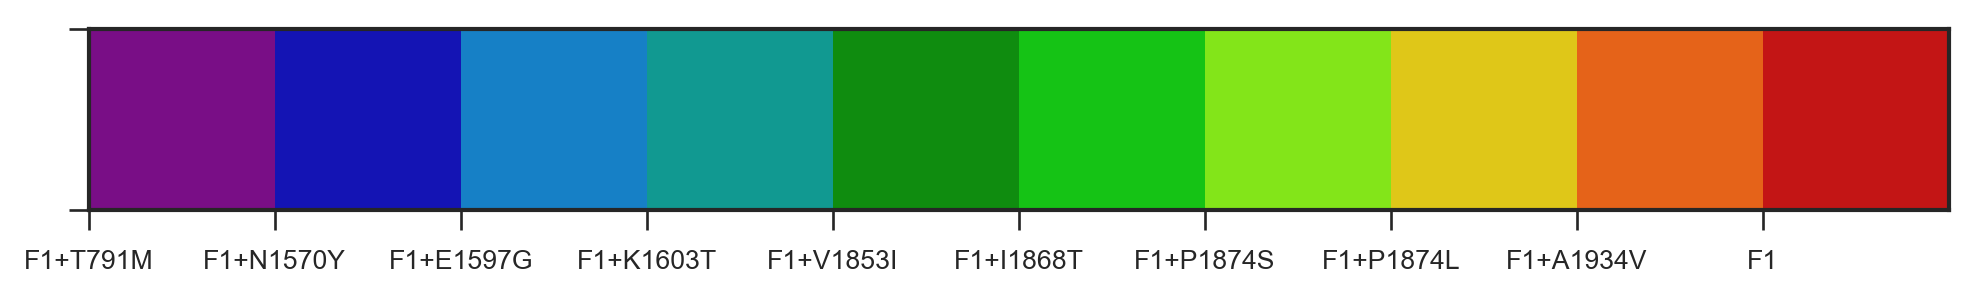

In [60]:
f_breakdown_palette = sns.color_palette('nipy_spectral', n_colors=len(f_breakdown), desat=0.8)
sns.palplot(f_breakdown_palette)
plt.gca().set_xticklabels(f_breakdown_labels)
f_breakdown_colors = dict(zip(f_breakdown_labels, f_breakdown_palette))  # don't include wt

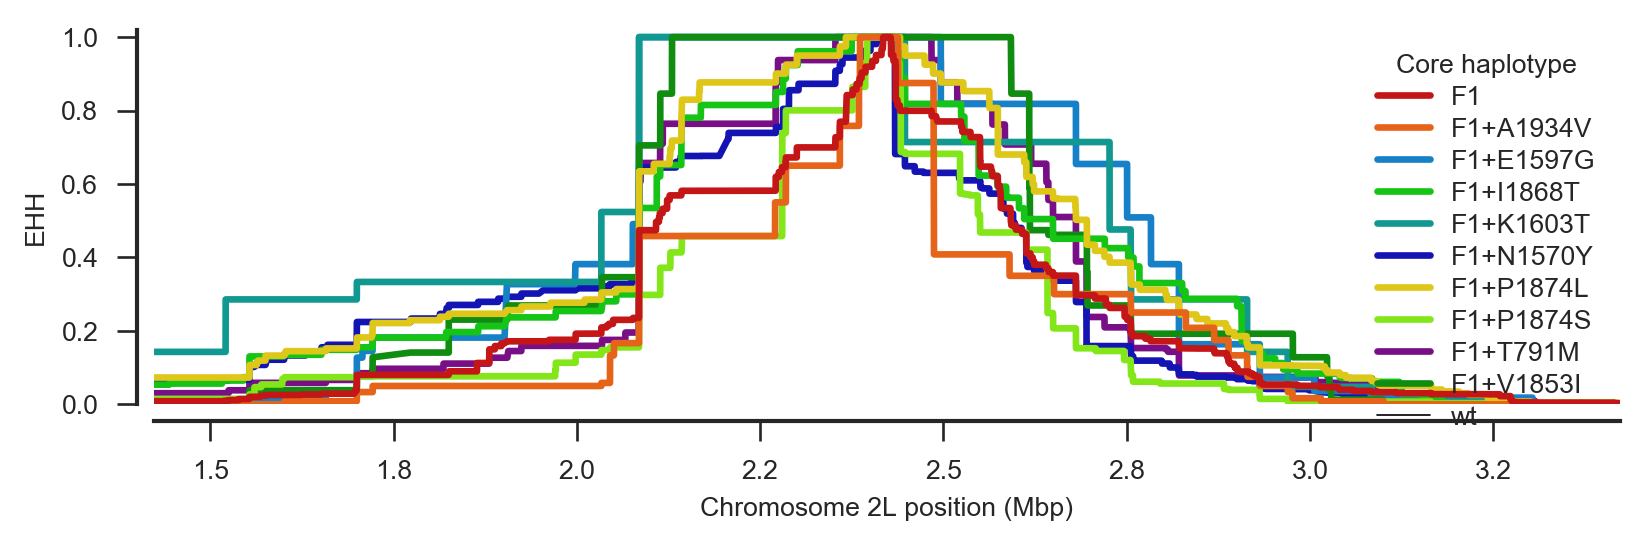

In [61]:
plot_ehh_decay(aa2pos['L995S'], f_breakdown, cluster_colors=f_breakdown_colors)

## Compare core haplotypes

In [62]:
import hapclust

In [63]:
# set core SNP
core_pos = aa2pos['L995S']

In [64]:
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)

In [65]:
def pairwise_haplotype_sharing(haps, dist, jitter=False):
    
    haps = allel.HaplotypeArray(haps)
    n_haplotypes = haps.n_haplotypes

    # compute length (no. variants) of shared prefix between pairs
    pspl = allel.opt.stats.pairwise_shared_prefix_lengths(
        np.asarray(haps, dtype='i1')
    )

    # compute length (physical distance) of shared prefix between neighbours
    pspd = hapclust._shared_distance(pspl, dist, jitter=jitter)

    return pspd


In [66]:
@functools.lru_cache(maxsize=None)
def compute_pspd(hap_ixs):
    
    # compute pairwise shared prefix distance
    pspd_left = pairwise_haplotype_sharing(haps_ehh_left.take(hap_ixs, axis=1), dist_ehh_left, jitter=True)
    pspd_right = pairwise_haplotype_sharing(haps_ehh_right.take(hap_ixs, axis=1), dist_ehh_right, jitter=True)
    
    return pspd_left, pspd_right

In [67]:
core_haps_dict = dict(core_haps)

In [68]:
core_hap_labels = sorted([l for l, _ in core_haps])

In [69]:
pspds = [compute_pspd(tuple(sorted(core_haps_dict[l]))) for l in core_hap_labels]

In [70]:
pspds_adjusted = [pl * 0.3 * 2e-6 + pr * 2e-6 for pl, pr in pspds]

In [71]:
def boxplot_pspds(x, xlabels, figsize=(7, 3), colors=None, fn=None, ylabel=None, save_dpi=150):
    
    fig, ax = plt.subplots(figsize=figsize)
    bx = ax.boxplot(x, notch=True, bootstrap=1000, whis=[5, 95], showfliers=False, 
                    patch_artist=True,
                    medianprops=dict(linestyle='-', color='k'))
    #ax.set_yscale('log')
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Core haplotype')
    if ylabel:
        ax.set_ylabel(ylabel)
    if colors:
        for patch, color in zip(bx['boxes'], colors):
                patch.set_facecolor(color)
                
    ax.grid(axis='y')
    #ax.set_ylim(bottom=100000);
    if fn:
        fig.savefig(fn, bbox_inches='tight', dpi=save_dpi, jpeg_quality=100)


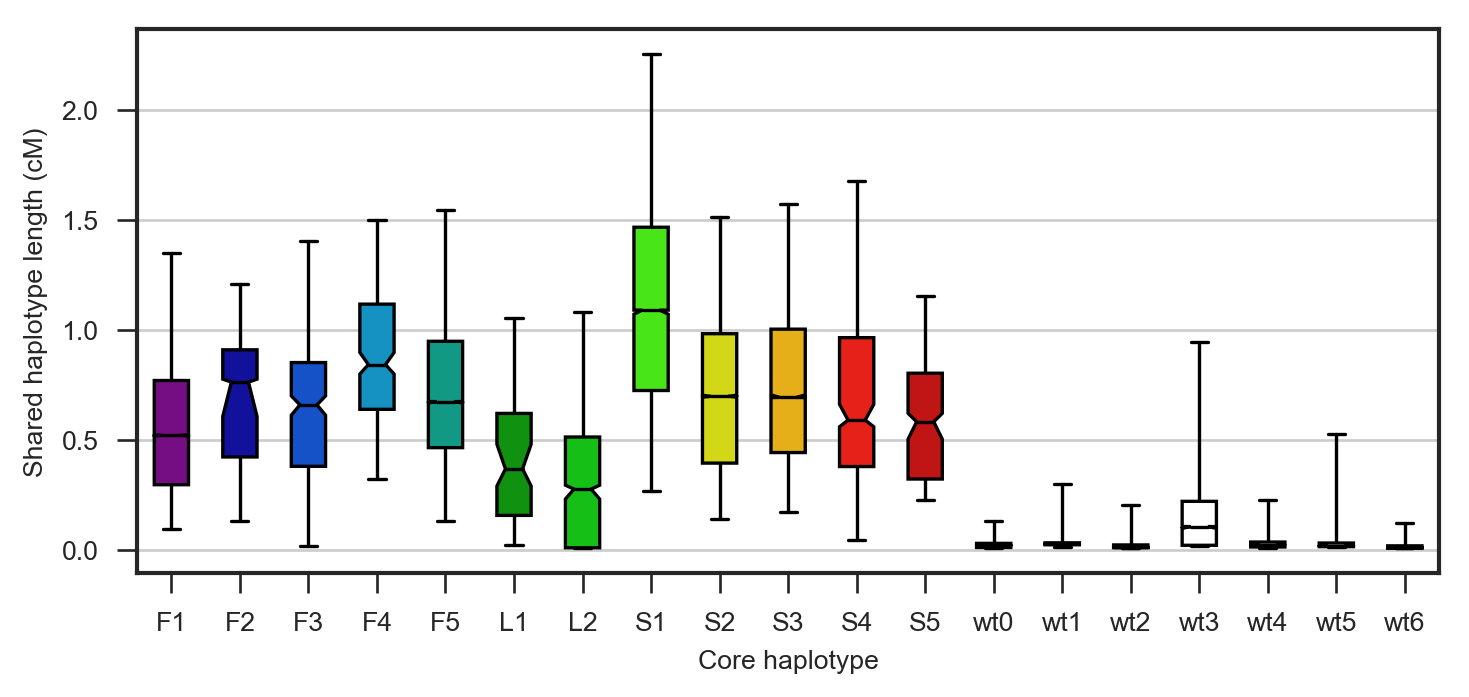

In [72]:
boxplot_pspds(pspds_adjusted, core_hap_labels, 
              colors=[cluster_colors.get(k, 'w') for k in core_hap_labels],
              fn='../artwork/clusters_compare_pspd.pdf', 
              ylabel='Shared haplotype length (cM)');

In [74]:
import scikits.bootstrap as bootstrap

In [82]:
for x, l in zip(pspds_adjusted, core_hap_labels):
    ci = bootstrap.ci(x, statfunction=np.median, n_samples=10000, method='pi')
    print('{} median {:.3f} cM (95% CI [{:.3f} - {:.3f}])'.format(l, np.median(x), ci[0], ci[1]))

F1 median 0.522 cM (95% CI [0.520 - 0.524])
F2 median 0.764 cM (95% CI [0.608 - 0.777])
F3 median 0.661 cM (95% CI [0.614 - 0.702])
F4 median 0.844 cM (95% CI [0.801 - 0.874])
F5 median 0.675 cM (95% CI [0.669 - 0.676])
L1 median 0.369 cM (95% CI [0.292 - 0.479])
L2 median 0.278 cM (95% CI [0.232 - 0.336])
S1 median 1.091 cM (95% CI [1.076 - 1.091])
S2 median 0.699 cM (95% CI [0.696 - 0.705])
S3 median 0.694 cM (95% CI [0.693 - 0.706])
S4 median 0.591 cM (95% CI [0.557 - 0.663])
S5 median 0.584 cM (95% CI [0.508 - 0.622])
wt0 median 0.023 cM (95% CI [0.020 - 0.025])
wt1 median 0.027 cM (95% CI [0.027 - 0.028])
wt2 median 0.012 cM (95% CI [0.012 - 0.012])
wt3 median 0.107 cM (95% CI [0.099 - 0.107])
wt4 median 0.026 cM (95% CI [0.019 - 0.030])
wt5 median 0.021 cM (95% CI [0.017 - 0.023])
wt6 median 0.012 cM (95% CI [0.010 - 0.012])


In [84]:
for x, l in zip(pspds_adjusted, core_hap_labels):
    ci = bootstrap.ci(x, statfunction=np.median, n_samples=10000, method='bca')
    print('{} median {:.3f} cM (95% CI [{:.3f} - {:.3f}])'.format(l, np.median(x), ci[0], ci[1]))

F1 median 0.522 cM (95% CI [0.520 - 0.524])
F2 median 0.764 cM (95% CI [0.608 - 0.777])
F3 median 0.661 cM (95% CI [0.614 - 0.702])
F4 median 0.844 cM (95% CI [0.801 - 0.874])
F5 median 0.675 cM (95% CI [0.669 - 0.676])
L1 median 0.369 cM (95% CI [0.292 - 0.479])
L2 median 0.278 cM (95% CI [0.223 - 0.330])


/home/aliman/src/github/alimanfoo/agam-vgsc-report/deps/conda/envs/agam-vgsc-report/lib/python3.6/site-packages/ipykernel_launcher.py:2: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  
/home/aliman/src/github/alimanfoo/agam-vgsc-report/deps/conda/envs/agam-vgsc-report/lib/python3.6/site-packages/ipykernel_launcher.py:2: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  


S1 median 1.091 cM (95% CI [1.070 - 1.070])
S2 median 0.699 cM (95% CI [0.696 - 0.705])
S3 median 0.694 cM (95% CI [0.693 - 0.706])
S4 median 0.591 cM (95% CI [0.557 - 0.663])
S5 median 0.584 cM (95% CI [0.502 - 0.622])
wt0 median 0.023 cM (95% CI [0.020 - 0.025])
wt1 median 0.027 cM (95% CI [0.027 - 0.028])


/home/aliman/src/github/alimanfoo/agam-vgsc-report/deps/conda/envs/agam-vgsc-report/lib/python3.6/site-packages/ipykernel_launcher.py:2: InstabilityWarning: BCa acceleration values for indexes (array([0]),) were undefined. Statistic values were likely all equal. Affected CI will be inaccurate.
  
/home/aliman/src/github/alimanfoo/agam-vgsc-report/deps/conda/envs/agam-vgsc-report/lib/python3.6/site-packages/ipykernel_launcher.py:2: InstabilityWarning: Some values were NaN; results are probably unstable (all values were probably equal)
  


wt2 median 0.012 cM (95% CI [0.012 - 0.012])
wt3 median 0.107 cM (95% CI [0.034 - 0.107])
wt4 median 0.026 cM (95% CI [0.019 - 0.030])
wt5 median 0.021 cM (95% CI [0.017 - 0.023])
wt6 median 0.012 cM (95% CI [0.010 - 0.012])
